### Group Project

Authors: Darren Singh, Dhari Gandhi, Sabrina Renna, Vivek Pereira, Yaosheng Liu, Zabihullah Zabih    

General Flow of the Notebook:

* After importing the necessary libraries / modules and reading in the data we will begin with data cleaning.

* This will be followed by an exploratory analysis, and then some feature engineering will be done.

* The modelling phase will be the final part of this notebook and will include conclusions

Please note that each cell assumes that only the cells before it have been run

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_recall_curve, precision_score, roc_auc_score, roc_curve, accuracy_score, mean_squared_error, confusion_matrix, classification_report
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier

### Read in Data

In [2]:
data = pd.read_csv('unified_payments.csv')
data.head()

id          Description     Seller Message   
0  ch_3NOsCuI0IKHUYx9W1HCqn8Mx                  NaN  Payment complete.  \
1  ch_3NOsCrI0IKHUYx9W1UPKK5lA                  NaN  Payment complete.   
2  ch_3NOpTUI0IKHUYx9W0su10iYi  Ticket Subscription  Payment complete.   
3  ch_3NOpTQI0IKHUYx9W0I8pPMmd  Ticket Subscription  Payment complete.   
4  ch_3NOpTOI0IKHUYx9W041AYyrt  Ticket Subscription  Payment complete.   

      Created (UTC)  Amount    Status                        Card ID   
0   2023-07-01 1:02    19.0      Paid  card_1NOsCuI0IKHUYx9WXBF00fK7  \
1   2023-07-01 1:02     1.0  Refunded  card_1NOsCrI0IKHUYx9WFZIMvALV   
2  2023-06-30 22:07    94.0      Paid  card_1NOpTUI0IKHUYx9WaKe13D4g   
3  2023-06-30 22:07    13.0      Paid  card_1NOpTQI0IKHUYx9WizKidsFO   
4  2023-06-30 22:07    35.0      Paid  card_1NOpTOI0IKHUYx9WEpnGbDUg   

   Card Brand Card Funding Card Address City Card Address State   
0  MasterCard       credit          PARADISE                 SA  \
1  MasterCard       credit          PARADISE                 SA   
2  MasterCard        debit           Lecanto                 FL   
3  MasterCard        debit            Dundee                 MI   
4  MasterCard       credit           Carlton                NSW   

  Card Address Country Card Issue Country  Card Fingerprint  Disputed Amount   
0                   AU                 AU  EHno1gCBcIfyELwX              NaN  \
1                   AU                 AU  EHno1gCBcIfyELwX              NaN   
2                   US                 US  HFuQBeC8TeWfIK7s              NaN   
3                   US                 US  UT156n14F6Rd4V35              NaN   
4                   AU                 AU  Cctzc15p1gzfn4R9              NaN   

  Dispute Status Dispute Reason Dispute Date (UTC)  
0            NaN            NaN                NaN  
1            NaN            NaN                NaN  
2            NaN            NaN                NaN  
3            NaN            NaN                NaN  
4            NaN            NaN                NaN

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91491 entries, 0 to 91490
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    91491 non-null  object 
 1   Description           81860 non-null  object 
 2   Seller Message        91490 non-null  object 
 3   Created (UTC)         91491 non-null  object 
 4   Amount                91491 non-null  float64
 5   Status                91491 non-null  object 
 6   Card ID               91491 non-null  object 
 7   Card Brand            91491 non-null  object 
 8   Card Funding          91491 non-null  object 
 9   Card Address City     91478 non-null  object 
 10  Card Address State    90954 non-null  object 
 11  Card Address Country  91440 non-null  object 
 12  Card Issue Country    91449 non-null  object 
 13  Card Fingerprint      91491 non-null  object 
 14  Disputed Amount       313 non-null    float64
 15  Dispute Status     

### Data Cleaning

General Overview:

* Some invalid obervations were dropped immediately, these were known to exist in the dataset beforehand.

* Then missing observations in the Description column were replaced with 'promo' as this was a data quality issue known beforehand.

* Missing records among the other columns were dropped as they represented less than 1% of the data

* A single record was found with a null seller message, this was dropped.

* No notable outliers were found.

In [4]:
# drop some invalid records
invalid_obs = ['Premium Service', 'Test Product', 'Recurring Payment','Platinum Template', 'PAYMENT - THANK YOU', 'AMAZON AWS']
data.drop(data[data['Description'].isin(invalid_obs)].index, inplace=True)

# drop missing observations (accounts for 1% of total values)
data.dropna(subset=['Card Address State'], inplace=True)
data.dropna(subset=['Card Address Country'], inplace=True)
data.dropna(subset=['Card Issue Country'], inplace=True)
data.dropna(subset=['Seller Message'], inplace=True)
data.dropna(subset=['Card Address City'], inplace=True)

In [5]:
# need to fill in missing data

# check what the possible unique values of the description column look like
data['Description'].unique()

# replace all missing data in description column with promo
data['Description'].fillna(value='promo', inplace=True)

In [6]:
# verify filling worked
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90815 entries, 0 to 91490
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    90815 non-null  object 
 1   Description           90815 non-null  object 
 2   Seller Message        90815 non-null  object 
 3   Created (UTC)         90815 non-null  object 
 4   Amount                90815 non-null  float64
 5   Status                90815 non-null  object 
 6   Card ID               90815 non-null  object 
 7   Card Brand            90815 non-null  object 
 8   Card Funding          90815 non-null  object 
 9   Card Address City     90815 non-null  object 
 10  Card Address State    90815 non-null  object 
 11  Card Address Country  90815 non-null  object 
 12  Card Issue Country    90815 non-null  object 
 13  Card Fingerprint      90815 non-null  object 
 14  Disputed Amount       313 non-null    float64
 15  Dispute Status        31

In [7]:
# 1 seller message is null
# drop this record for now
data.drop(data[data['Seller Message'].isna()].index, inplace=True)

# correct extra space in description
# change 'Ticket Suscription ' to 'Ticket Subscription' in the Description column
data['Description'] = data['Description'].replace(['Ticket Subscription '], 'Ticket Subscription')
data.reset_index()

# verify null record was dropped
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90815 entries, 0 to 91490
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    90815 non-null  object 
 1   Description           90815 non-null  object 
 2   Seller Message        90815 non-null  object 
 3   Created (UTC)         90815 non-null  object 
 4   Amount                90815 non-null  float64
 5   Status                90815 non-null  object 
 6   Card ID               90815 non-null  object 
 7   Card Brand            90815 non-null  object 
 8   Card Funding          90815 non-null  object 
 9   Card Address City     90815 non-null  object 
 10  Card Address State    90815 non-null  object 
 11  Card Address Country  90815 non-null  object 
 12  Card Issue Country    90815 non-null  object 
 13  Card Fingerprint      90815 non-null  object 
 14  Disputed Amount       313 non-null    float64
 15  Dispute Status        31

### Exploratory Analysis

Many trends were examined in the exploratory data analysis but the key trends will be summarized here:

* It was noted that there did appear to be some form of a correlation between the seller message and the card funding. Though the correlation did not appear to be linear.

* There also appears to be a relationship between seller message and description, although it also appears to be non-linear.

* The key takeaway here is that there does appear to be variables present that can aid in predicting the seller message

In [8]:
# begin looking at relations

# this analysis will not focus on disputes, drop these columns
data.drop(['Disputed Amount', 'Dispute Status', 'Dispute Reason', 'Dispute Date (UTC)'], axis=1, inplace=True)

data.describe(include='all')

id          Description     Seller Message   
count                         90815                90815              90815  \
unique                        90815                    3                 32   
top     ch_3NOsCuI0IKHUYx9W1HCqn8Mx  Ticket Subscription  Payment complete.   
freq                              1                74499              66778   
mean                            NaN                  NaN                NaN   
std                             NaN                  NaN                NaN   
min                             NaN                  NaN                NaN   
25%                             NaN                  NaN                NaN   
50%                             NaN                  NaN                NaN   
75%                             NaN                  NaN                NaN   
max                             NaN                  NaN                NaN   

           Created (UTC)        Amount Status                        Card ID   
count              90815  90815.000000  90815                          90815  \
unique             16372           NaN      3                          90815   
top     2022-05-09 22:06           NaN   Paid  card_1NOsCuI0IKHUYx9WXBF00fK7   
freq                  29           NaN  61870                              1   
mean                 NaN     30.142498    NaN                            NaN   
std                  NaN     34.050442    NaN                            NaN   
min                  NaN      1.000000    NaN                            NaN   
25%                  NaN     13.000000    NaN                            NaN   
50%                  NaN     19.000000    NaN                            NaN   
75%                  NaN     35.000000    NaN                            NaN   
max                  NaN    249.000000    NaN                            NaN   

       Card Brand Card Funding Card Address City Card Address State   
count       90815        90815             90815              90815  \
unique          6            4              9423               2939   
top          Visa        debit            London                 CA   
freq        56780        45663               916               5391   
mean          NaN          NaN               NaN                NaN   
std           NaN          NaN               NaN                NaN   
min           NaN          NaN               NaN                NaN   
25%           NaN          NaN               NaN                NaN   
50%           NaN          NaN               NaN                NaN   
75%           NaN          NaN               NaN                NaN   
max           NaN          NaN               NaN                NaN   

       Card Address Country Card Issue Country  Card Fingerprint  
count                 90815              90815             90815  
unique                  133                112             19609  
top                      US                 US  RW9JFzy63TFkXAp3  
freq                  42006              41981                68  
mean                    NaN                NaN               NaN  
std                     NaN                NaN               NaN  
min                     NaN                NaN               NaN  
25%                     NaN                NaN               NaN  
50%                     NaN                NaN               NaN  
75%                     NaN                NaN               NaN  
max                     NaN                NaN               NaN

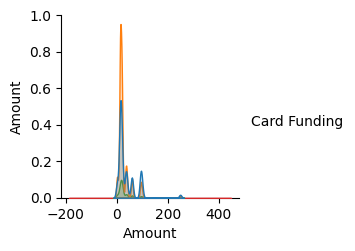

In [9]:
# nothing of interest as of now in the descriptive stats
# max amount of 249 seems high but is a subscription price

# do a quick pair plot
sns.pairplot(data, hue='Card Funding')

# does appear to be some relation between amount and card funding
# need to check, could be because there are more debit customers than credit as well

# also no disputed amount with prepaid cards?
# possible I guess
# also noting that there seems to be much less prepaid data than other card fundings

# does seem to be a correlation with disputed amounts and credit/debit
# but disputes represent a small chunk of the data

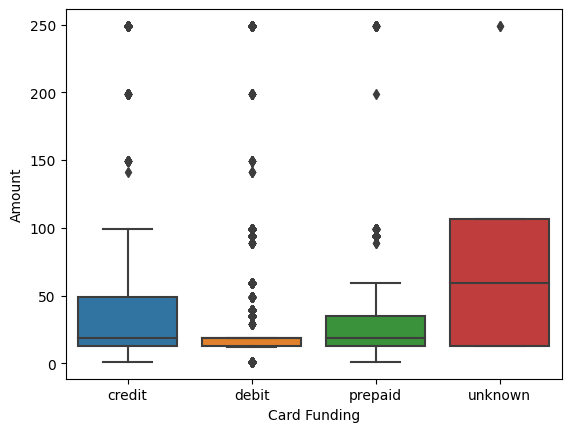

In [10]:
# some quick boxplots for numerical columns

sns.boxplot(x = 'Card Funding', y = 'Amount', data=data)
plt.show()

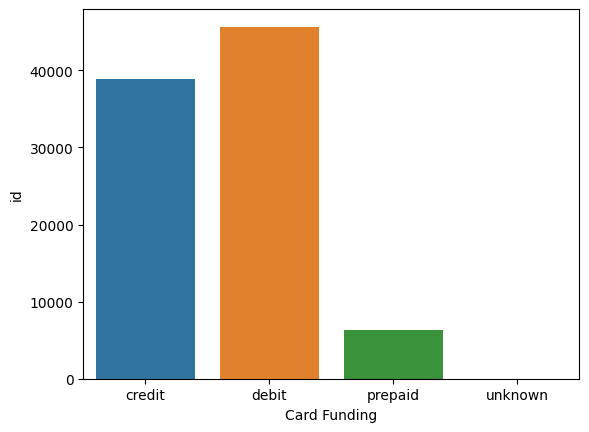

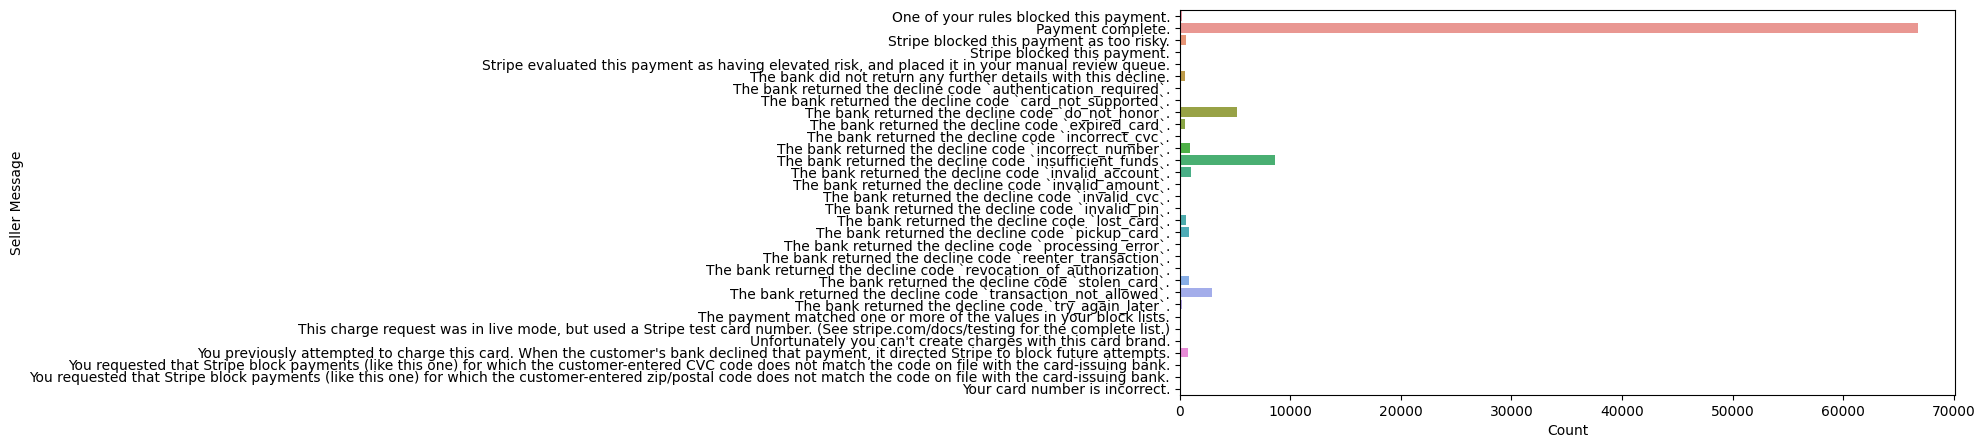

In [11]:
# check for data imbalances

cardTypes = data.groupby('Card Funding')
sns.barplot(x = cardTypes['id'].count().index, y = cardTypes['id'].count())
plt.show()

saleMessage = data.groupby('Seller Message')
plt.figure(figsize=(10,5))
sns.barplot(y = saleMessage['id'].count().index, x = saleMessage['id'].count())
plt.xlabel('Count')
plt.show()

<Axes: xlabel='count', ylabel='Seller Message'>

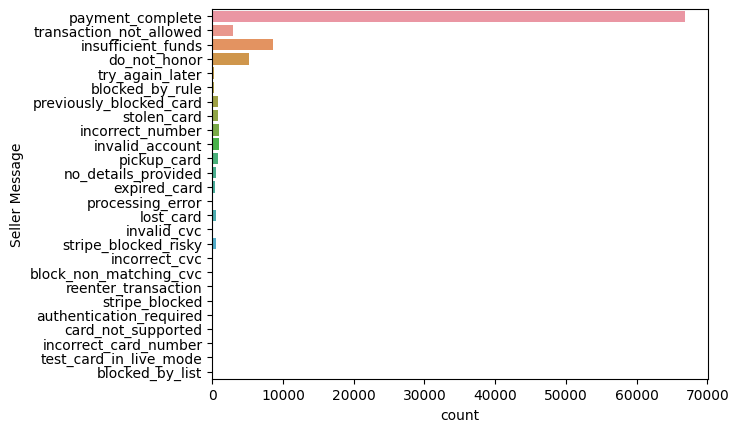

In [39]:
# generate same plot as above with smaller axis labels to better fit in the report

# Create a dictionary to map the long decline codes to their shorter names
short_names = {
    'Payment complete.': 'payment_complete',
    'The bank returned the decline code `transaction_not_allowed`.': 'transaction_not_allowed',
    'The bank returned the decline code `insufficient_funds`.': 'insufficient_funds',
    'The bank returned the decline code `do_not_honor`.': 'do_not_honor',
    'The bank returned the decline code `try_again_later`.': 'try_again_later',
    'One of your rules blocked this payment.': 'blocked_by_rule',
    "You previously attempted to charge this card. When the customer's bank declined that payment, it directed Stripe to block future attempts.": 'previously_blocked_card',
    'The bank returned the decline code `stolen_card`.': 'stolen_card',
    'The bank returned the decline code `incorrect_number`.': 'incorrect_number',
    'The bank returned the decline code `invalid_account`.': 'invalid_account',
    'The bank returned the decline code `pickup_card`.': 'pickup_card',
    'The bank did not return any further details with this decline.': 'no_details_provided',
    'The bank returned the decline code `expired_card`.': 'expired_card',
    'The bank returned the decline code `processing_error`.': 'processing_error',
    'The bank returned the decline code `lost_card`.': 'lost_card',
    'The bank returned the decline code `invalid_cvc`.': 'invalid_cvc',
    'Stripe blocked this payment as too risky.': 'stripe_blocked_risky',
    'The bank returned the decline code `incorrect_cvc`.': 'incorrect_cvc',
    'You requested that Stripe block payments (like this one) for which the customer-entered CVC code does not match the code on file with the card-issuing bank.': 'block_non_matching_cvc',
    'The bank returned the decline code `reenter_transaction`.': 'reenter_transaction',
    'Stripe blocked this payment.': 'stripe_blocked',
    'The bank returned the decline code `authentication_required`.': 'authentication_required',
    'The bank returned the decline code `card_not_supported`.': 'card_not_supported',
    'Your card number is incorrect.': 'incorrect_card_number',
    'This charge request was in live mode, but used a Stripe test card number. (See stripe.com/docs/testing for the complete list.)': 'test_card_in_live_mode',
    'The payment matched one or more of the values in your block lists.': 'blocked_by_list'
}

# create copy of dataframe to create new mapping column on

df2 = data

# Example usage
df2['Seller Message'] = df2['Seller Message'].map(short_names)
sns.countplot(y='Seller Message', data=df2)

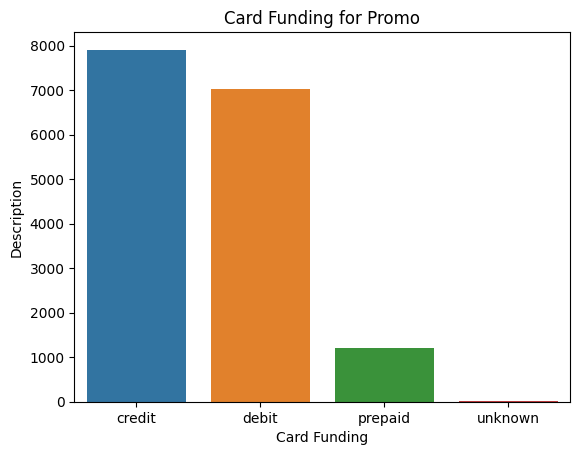

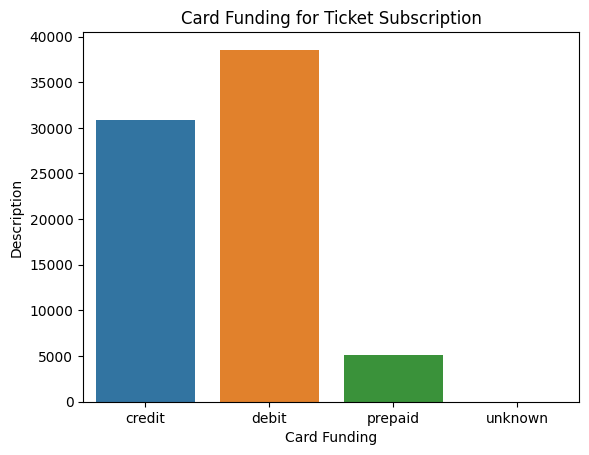

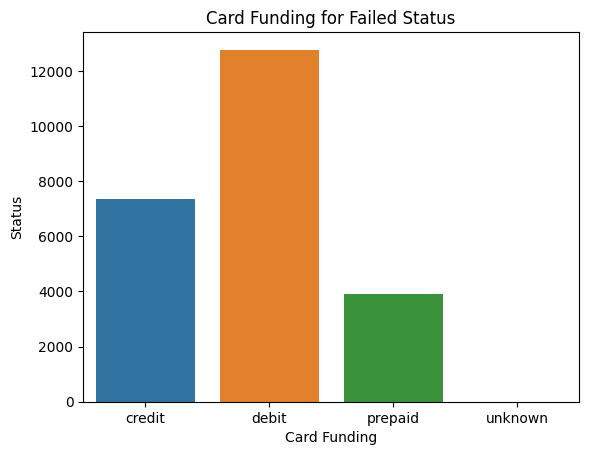

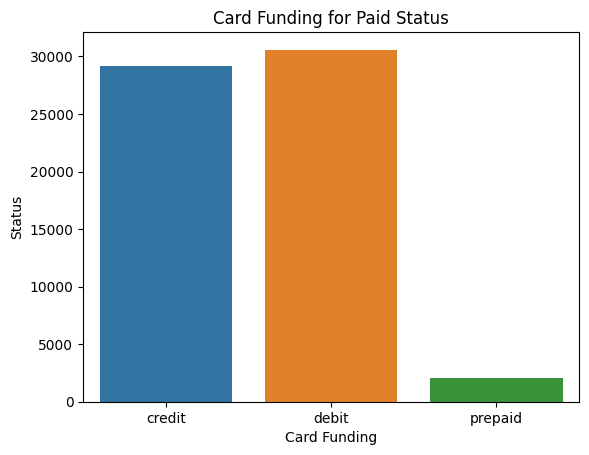

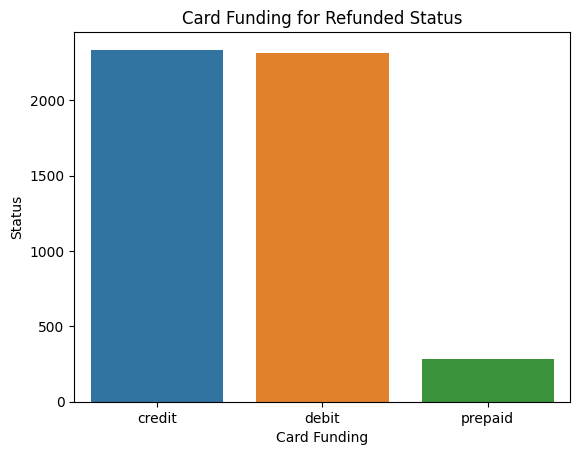

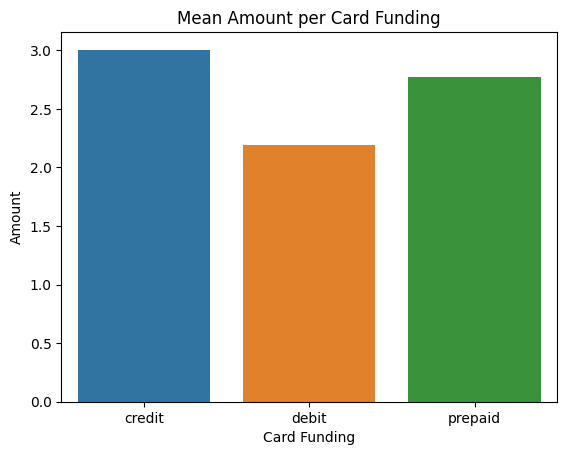

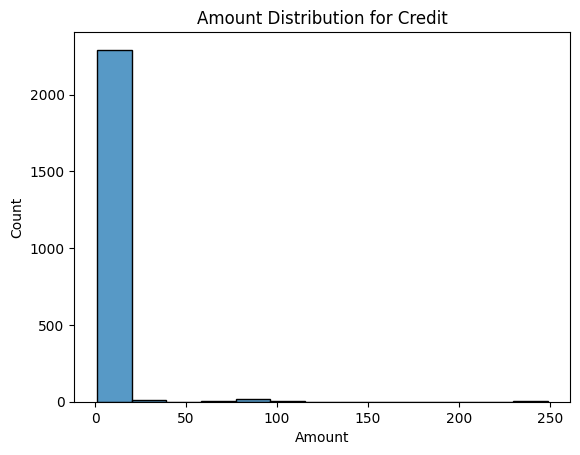

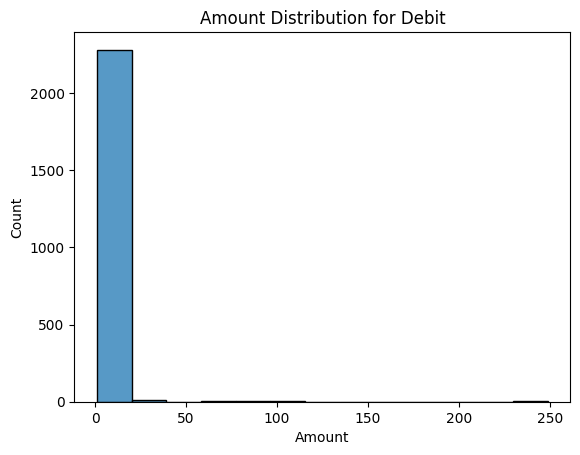

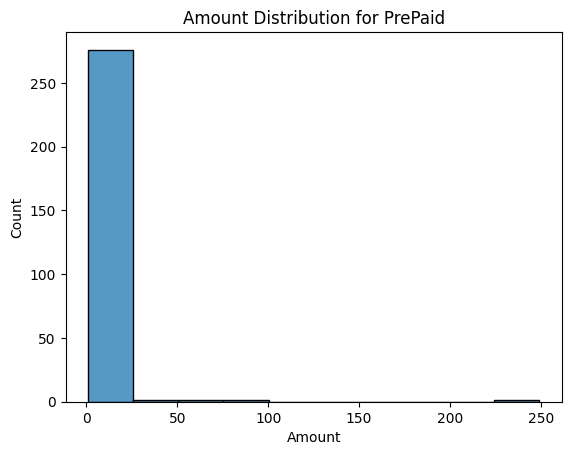

In [12]:
# check relations of card funding vs everything


# check relation with description

# filter by only data with promo
promo = data[data['Description'] == 'promo']
cards = promo.groupby('Card Funding')

sns.barplot(x = cards['Description'].count().index, y = cards['Description'].count())
plt.title('Card Funding for Promo')
plt.show()

# filter by only data with Ticket subscription
tickSub = data[data['Description'] == 'Ticket Subscription']
cards = tickSub.groupby('Card Funding')

sns.barplot(x = cards['Description'].count().index, y = cards['Description'].count())
plt.title('Card Funding for Ticket Subscription')
plt.show()

# ratios for card types for promo vs ticket subscription look similar 
# more data for ticket subscriptions
# doesnt seem to be much correlation between card funding and promo vs ticket subscription


# now check relation between status and card funding

# check what the unique values are
data['Status'].unique()

# split data
failed = data[data['Status'] == 'Failed']
paid = data[data['Status'] == 'Paid']
refund = data[data['Status'] == 'Refunded']

# generate plots
cards = failed.groupby('Card Funding')

sns.barplot(x = cards['Status'].count().index, y = cards['Status'].count())
plt.title('Card Funding for Failed Status')
plt.show()

cards = paid.groupby('Card Funding')

sns.barplot(x = cards['Status'].count().index, y = cards['Status'].count())
plt.title('Card Funding for Paid Status')
plt.show()

cards = refund.groupby('Card Funding')

sns.barplot(x = cards['Status'].count().index, y = cards['Status'].count())
plt.title('Card Funding for Refunded Status')
plt.show()

# somewhat similar stats for paid vs refunded, but much more data for paid
# different stats in failed vs paid, expected that much less credit cards fail

# check card funding vs amount
sns.barplot(x = cards['Amount'].mean().index, y = cards['Amount'].mean())
plt.title('Mean Amount per Card Funding')
plt.show()

# look at amount distribution per card funding
credit = cards.get_group('credit')
sns.histplot(x = credit['Amount'])
plt.title('Amount Distribution for Credit')
plt.show()

debit = cards.get_group('debit')
sns.histplot(x = debit['Amount'])
plt.title('Amount Distribution for Debit')
plt.show()

prepaid = cards.get_group('prepaid')
sns.histplot(x = prepaid['Amount'])
plt.title('Amount Distribution for PrePaid')
plt.show()

# mainly smaller transaction amounts for debit 
# larger for prepaid
# even larger for credit

Values by card funding for the following Seller Message: Payment complete.
               Seller Message
Card Funding                
credit                 31504
debit                  32891
prepaid                 2383


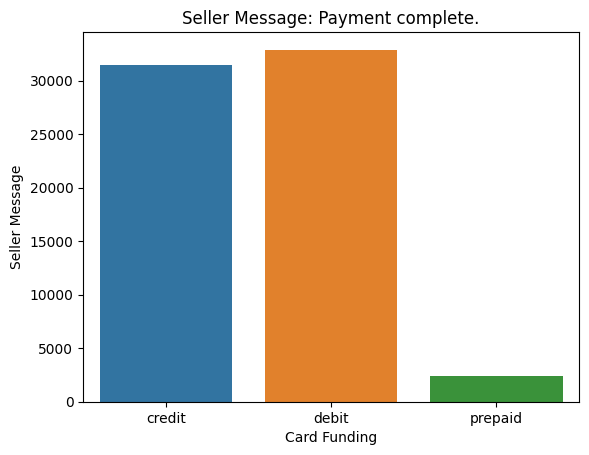

Values by card funding for the following Seller Message: The bank returned the decline code `transaction_not_allowed`.
               Seller Message
Card Funding                
credit                   992
debit                   1225
prepaid                  682


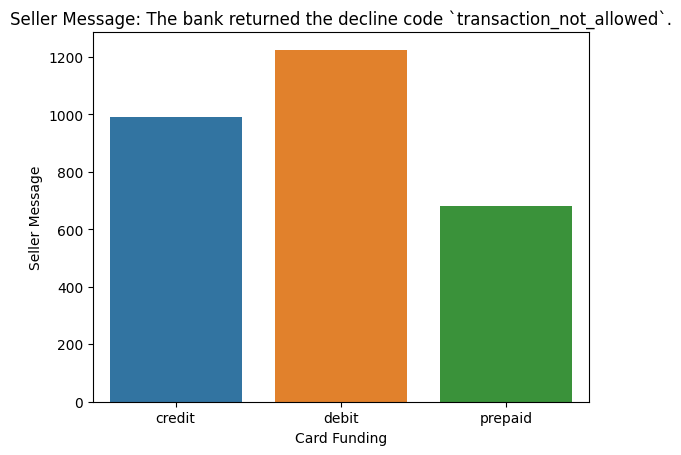

Values by card funding for the following Seller Message: The bank returned the decline code `insufficient_funds`.
               Seller Message
Card Funding                
credit                  1577
debit                   4951
prepaid                 2121


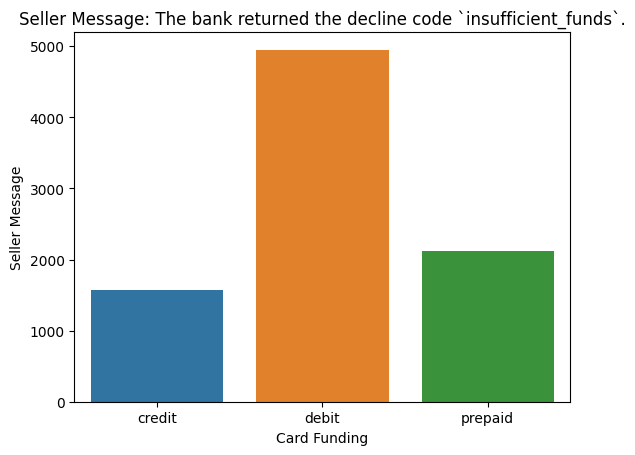

Values by card funding for the following Seller Message: The bank returned the decline code `do_not_honor`.
               Seller Message
Card Funding                
credit                  2022
debit                   2578
prepaid                  565


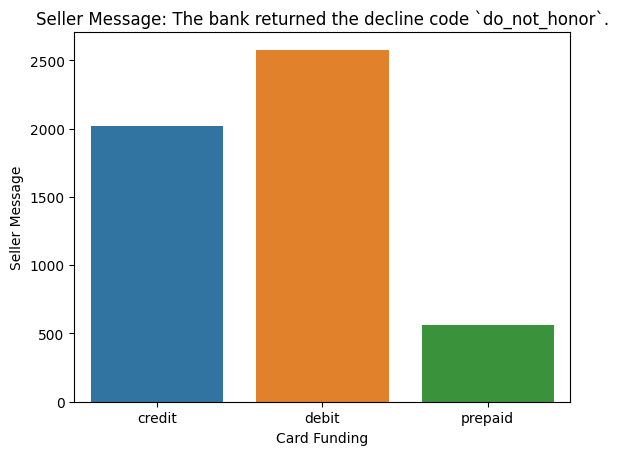

Values by card funding for the following Seller Message: The bank returned the decline code `try_again_later`.
               Seller Message
Card Funding                
credit                    57
debit                     95
prepaid                   34


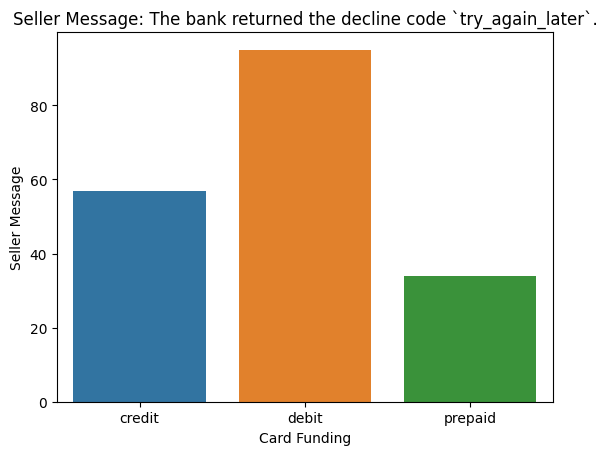

Values by card funding for the following Seller Message: One of your rules blocked this payment.
               Seller Message
Card Funding                
credit                    40
debit                    128
prepaid                   66


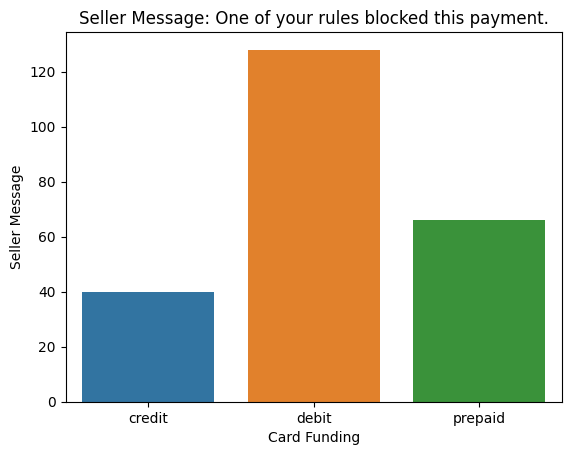

Values by card funding for the following Seller Message: You previously attempted to charge this card. When the customer's bank declined that payment, it directed Stripe to block future attempts.
               Seller Message
Card Funding                
credit                   289
debit                    382
prepaid                   79


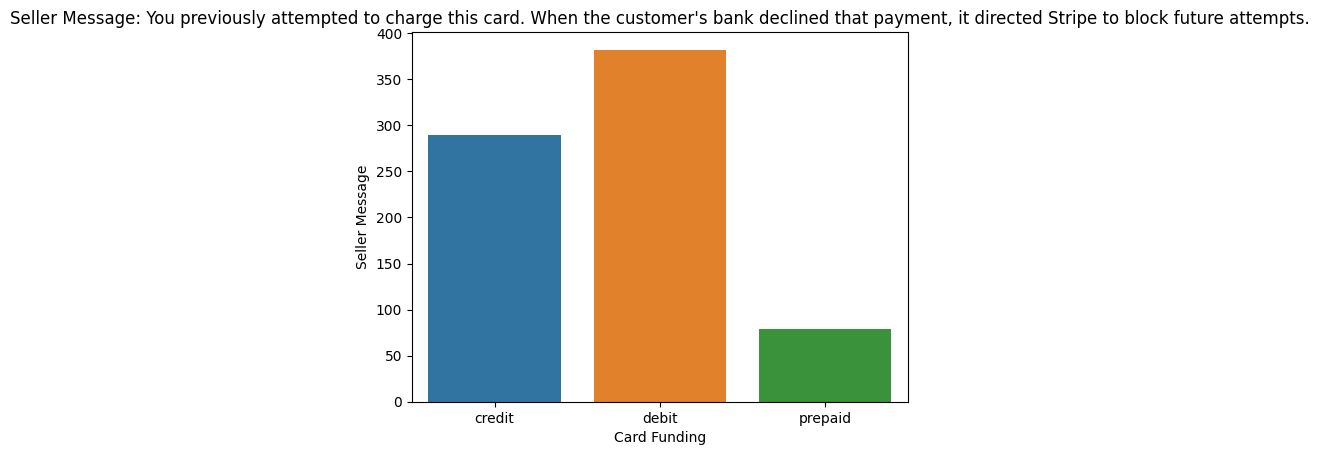

Values by card funding for the following Seller Message: The bank returned the decline code `stolen_card`.
               Seller Message
Card Funding                
credit                   187
debit                    567
prepaid                   52


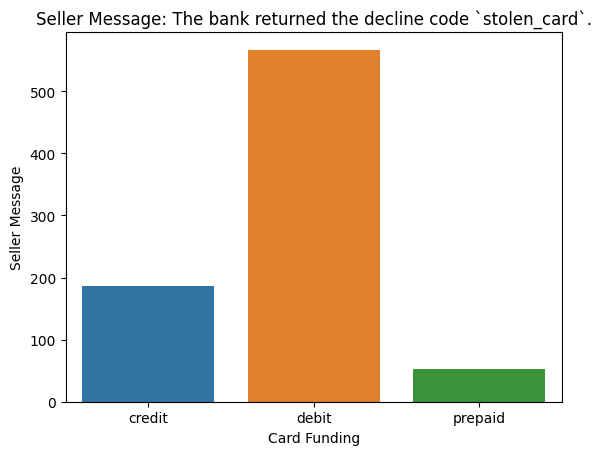

Values by card funding for the following Seller Message: The bank returned the decline code `incorrect_number`.
               Seller Message
Card Funding                
credit                   277
debit                    564
prepaid                   49
unknown                    4


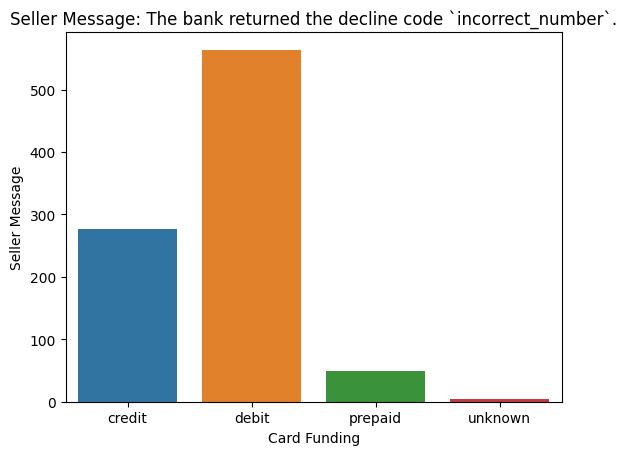

Values by card funding for the following Seller Message: The bank returned the decline code `invalid_account`.
               Seller Message
Card Funding                
credit                   330
debit                    603
prepaid                   45


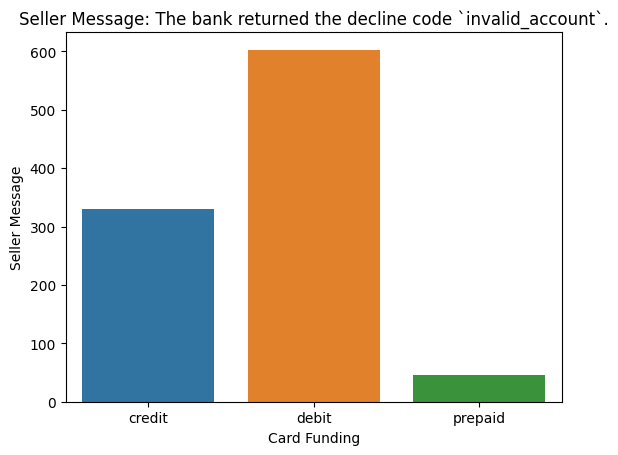

Values by card funding for the following Seller Message: The bank returned the decline code `pickup_card`.
               Seller Message
Card Funding                
credit                   428
debit                    365
prepaid                   64


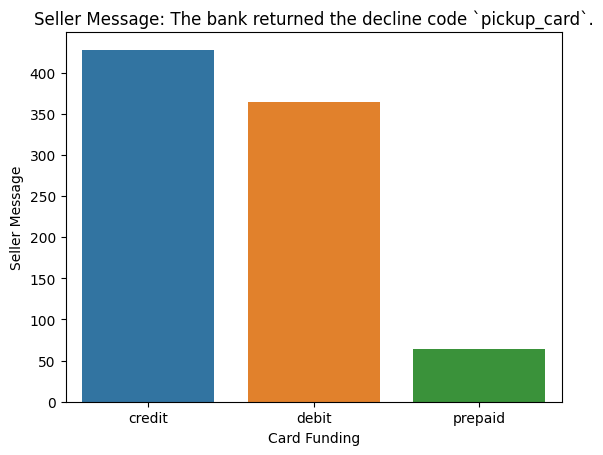

Values by card funding for the following Seller Message: The bank did not return any further details with this decline.
               Seller Message
Card Funding                
credit                   194
debit                    269
prepaid                   34


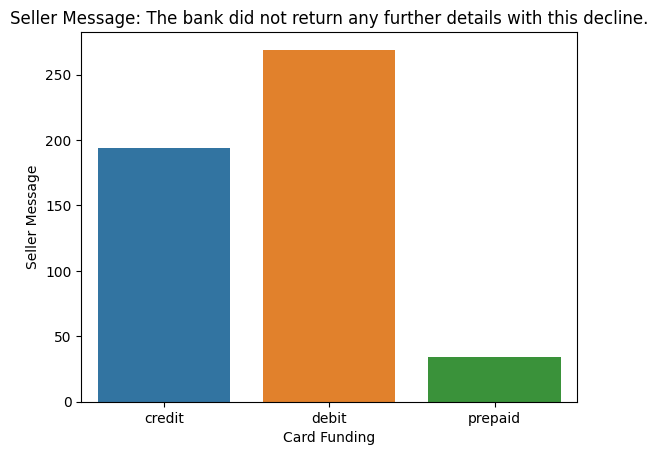

Values by card funding for the following Seller Message: The bank returned the decline code `expired_card`.
               Seller Message
Card Funding                
credit                   174
debit                    221
prepaid                   32


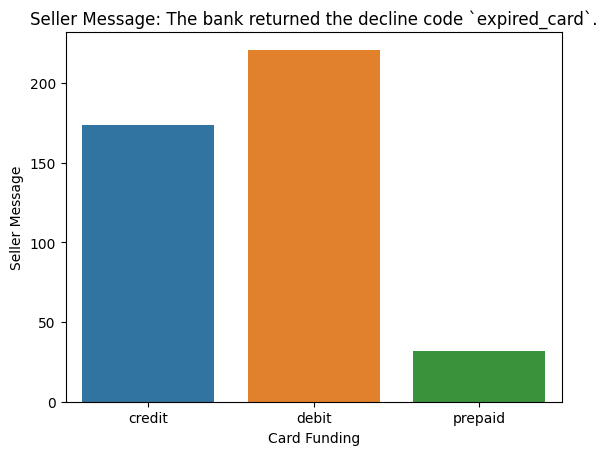

Values by card funding for the following Seller Message: The bank returned the decline code `processing_error`.
               Seller Message
Card Funding                
credit                    24
debit                     26
prepaid                    3


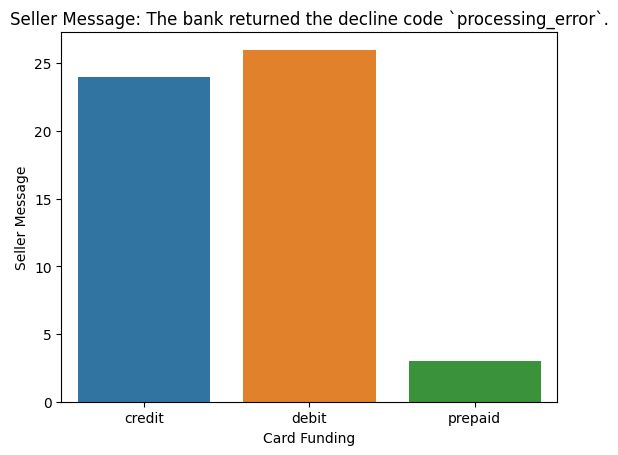

Values by card funding for the following Seller Message: The bank returned the decline code `lost_card`.
               Seller Message
Card Funding                
credit                   151
debit                    329
prepaid                   36


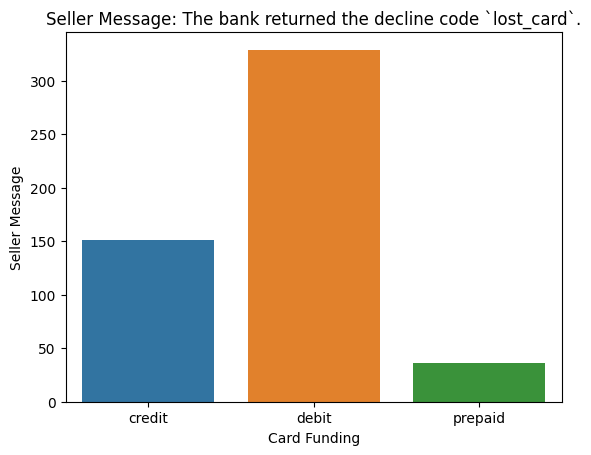

Values by card funding for the following Seller Message: The bank returned the decline code `invalid_cvc`.
               Seller Message
Card Funding                
credit                    27
debit                      5


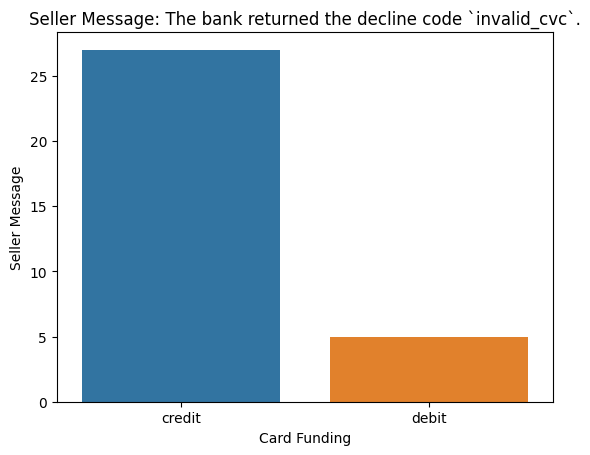

Values by card funding for the following Seller Message: Stripe blocked this payment as too risky.
               Seller Message
Card Funding                
credit                   282
debit                    272
prepaid                   10


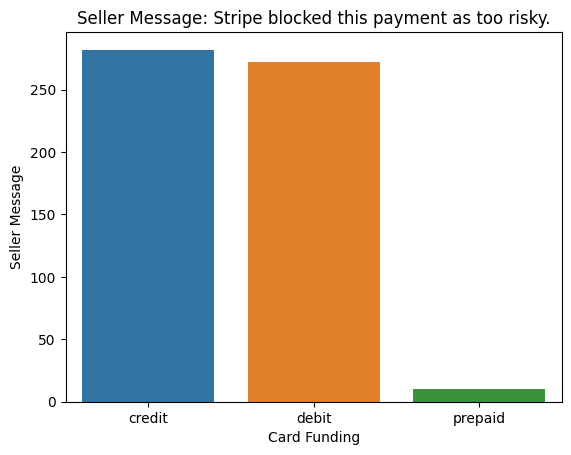

Values by card funding for the following Seller Message: The bank returned the decline code `incorrect_cvc`.
               Seller Message
Card Funding                
credit                    16
debit                     28
prepaid                    8


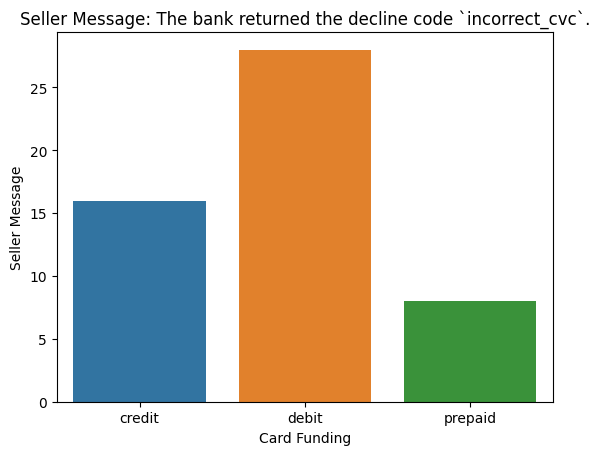

Values by card funding for the following Seller Message: You requested that Stripe block payments (like this one) for which the customer-entered CVC code does not match the code on file with the card-issuing bank.
               Seller Message
Card Funding                
credit                    80
debit                     51
prepaid                    4


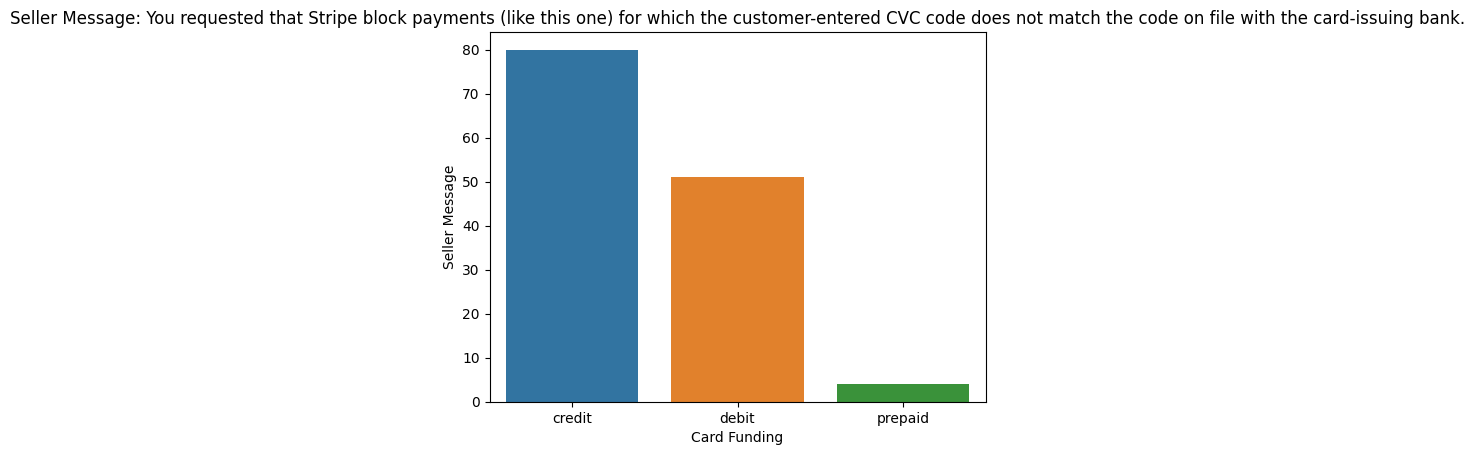

Values by card funding for the following Seller Message: The bank returned the decline code `reenter_transaction`.
               Seller Message
Card Funding                
credit                    17
debit                      8


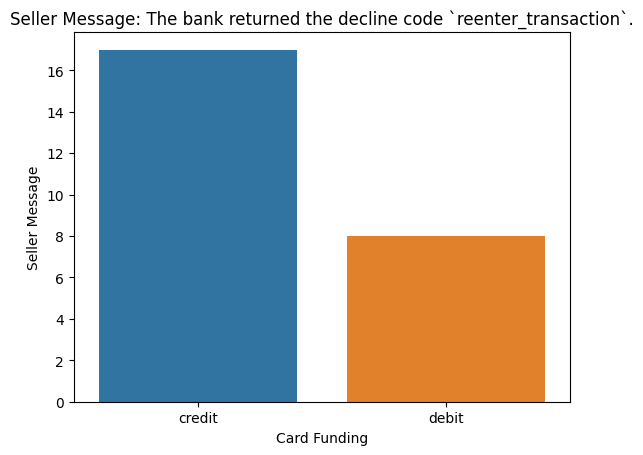

Values by card funding for the following Seller Message: Stripe blocked this payment.
               Seller Message
Card Funding                
debit                      2


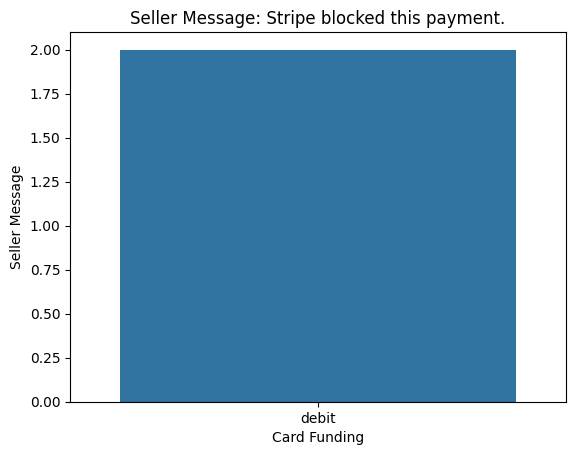

Values by card funding for the following Seller Message: The bank returned the decline code `authentication_required`.
               Seller Message
Card Funding                
credit                    70
debit                     37
prepaid                   20


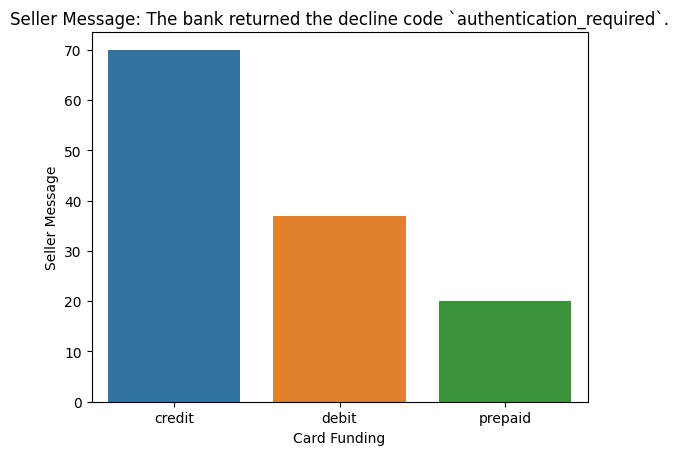

Values by card funding for the following Seller Message: The bank returned the decline code `card_not_supported`.
               Seller Message
Card Funding                
credit                    13


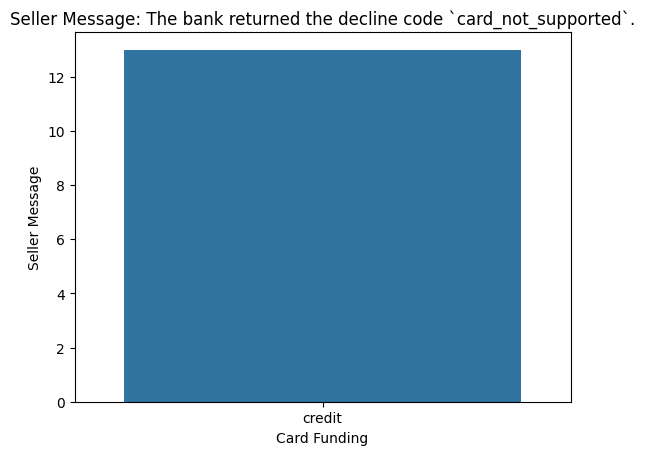

In [13]:
# now card fund vs seller message
# in its own cell because of large output

# list of possible seller messages
messages = ['Payment complete.', 'The bank returned the decline code `transaction_not_allowed`.', 'The bank returned the decline code `insufficient_funds`.',
       'The bank returned the decline code `do_not_honor`.', 'The bank returned the decline code `try_again_later`.', 'One of your rules blocked this payment.',
       "You previously attempted to charge this card. When the customer's bank declined that payment, it directed Stripe to block future attempts.",
       'The bank returned the decline code `stolen_card`.', 'The bank returned the decline code `incorrect_number`.', 'The bank returned the decline code `invalid_account`.',
       'The bank returned the decline code `pickup_card`.', 'The bank did not return any further details with this decline.',
       'The bank returned the decline code `expired_card`.', 'The bank returned the decline code `processing_error`.', 'The bank returned the decline code `lost_card`.',
       'The bank returned the decline code `invalid_cvc`.', 'Stripe blocked this payment as too risky.', 'The bank returned the decline code `incorrect_cvc`.',
       'You requested that Stripe block payments (like this one) for which the customer-entered CVC code does not match the code on file with the card-issuing bank.',
       'The bank returned the decline code `reenter_transaction`.', 'Stripe blocked this payment.', 'The bank returned the decline code `authentication_required`.',
       'The bank returned the decline code `card_not_supported`.']

# loop through all seller messages and print counts for each, generate plot as well
# could also generalize some, group all bank ones together or something

for message in messages:

       # filter all data by only entries with this particular seller message
       filteredData = data[data['Seller Message'] == message]

       # split into different card fundings
       cardFunds = filteredData.groupby('Card Funding')

       # output counts per card funding
       print("Values by card funding for the following Seller Message:",message + "\n", cardFunds['Seller Message'].count().to_frame())

       # plot
       sns.barplot(x = cardFunds['Seller Message'].count().index, y = cardFunds['Seller Message'].count())
       plt.title('Seller Message: ' + message)
       plt.show()


# looks to be some form of a correlation between seller message and card funding
# might be a non linear relationship by the looks of things

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription           53312
datapack                         22
promo                         13444


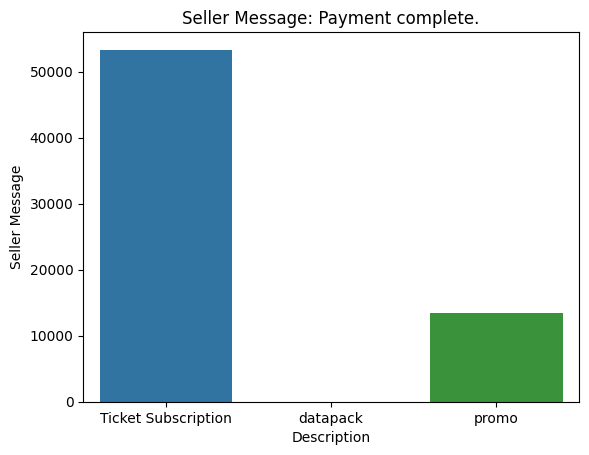

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription            2577
datapack                          1
promo                           321


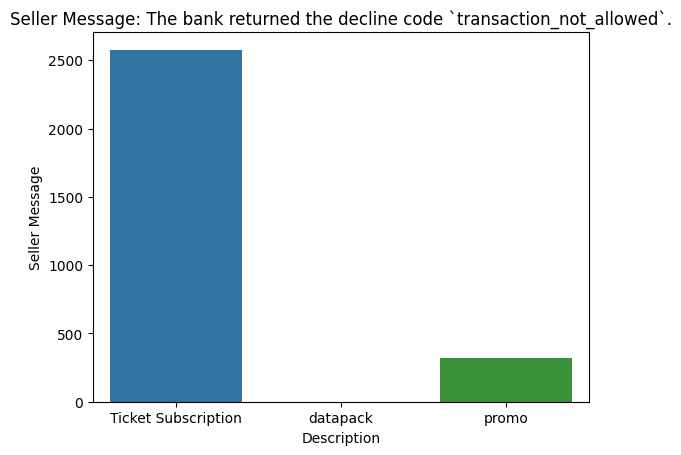

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription            8423
datapack                          8
promo                           218


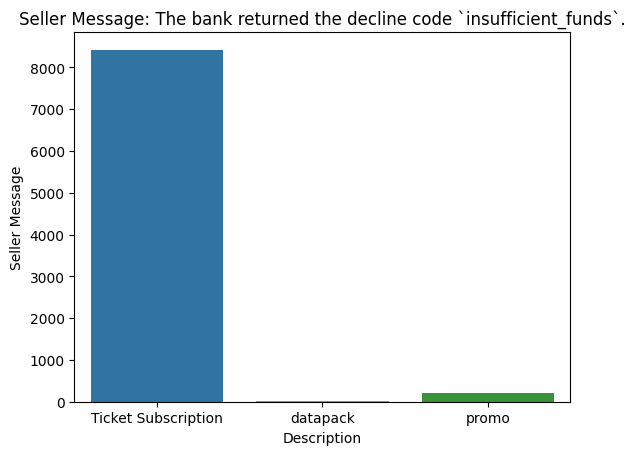

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription            4176
datapack                         23
promo                           966


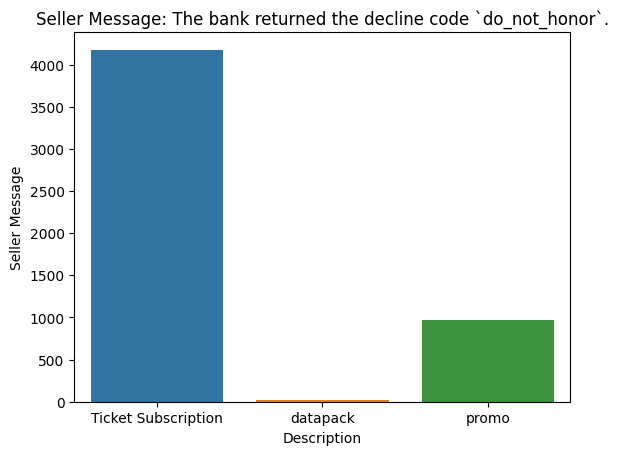

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription             105
promo                            81


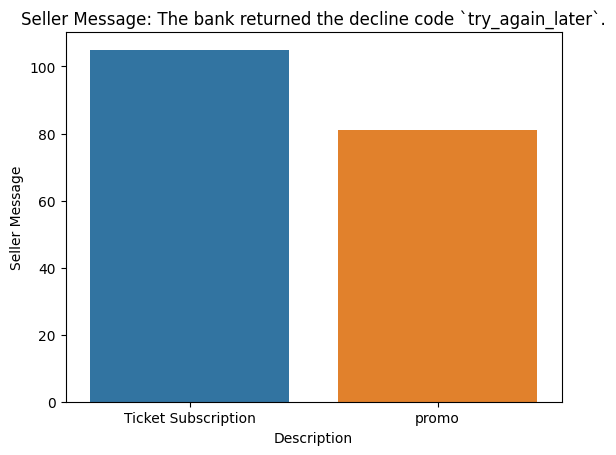

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription              41
promo                           193


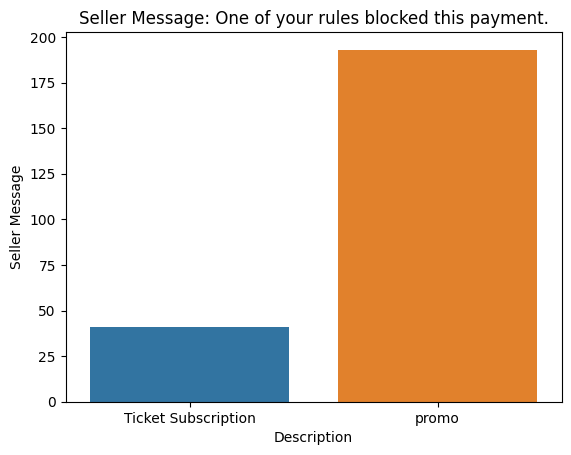

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription             675
promo                            75


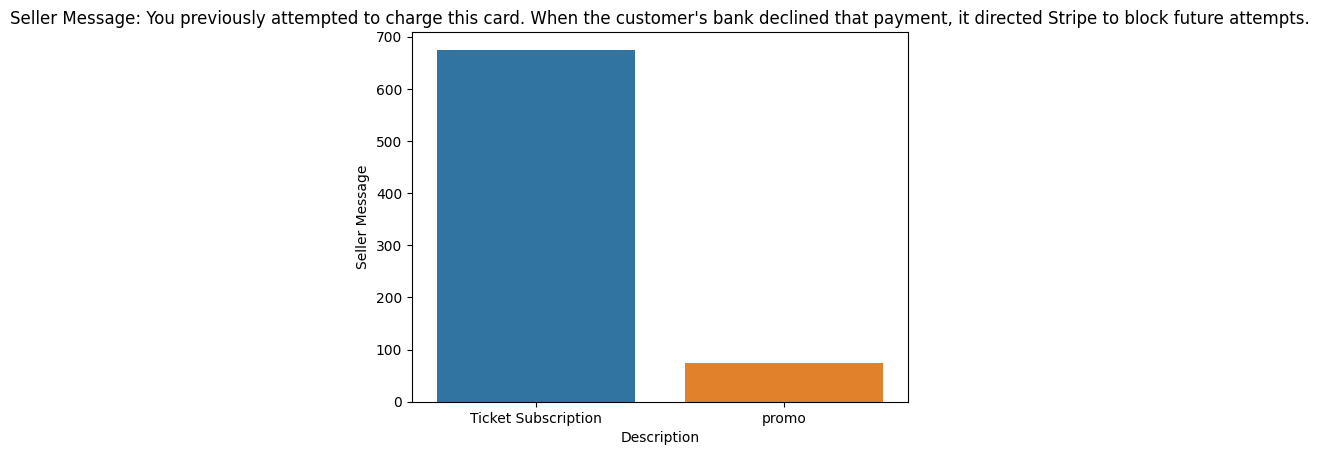

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription             799
datapack                          1
promo                             6


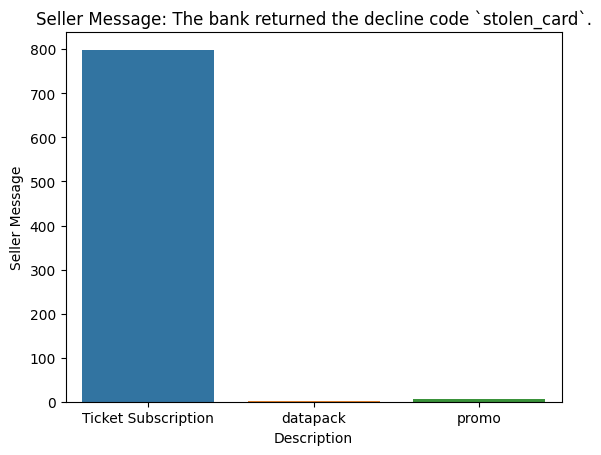

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription             831
datapack                         11
promo                            52


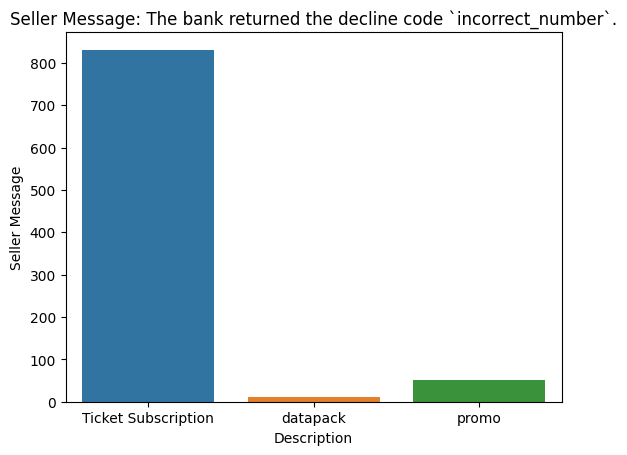

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription             955
promo                            23


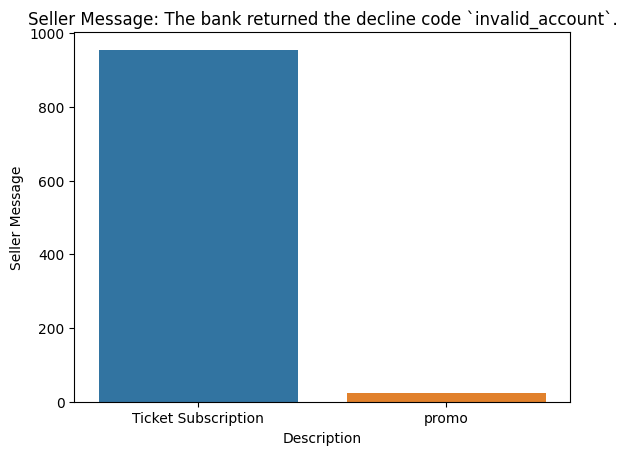

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription             850
datapack                          1
promo                             6


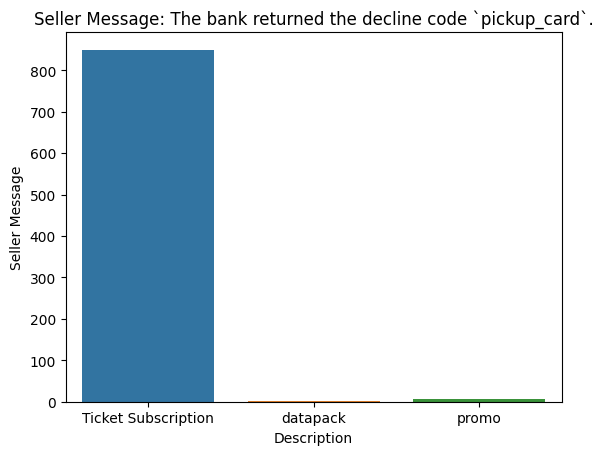

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription             317
promo                           180


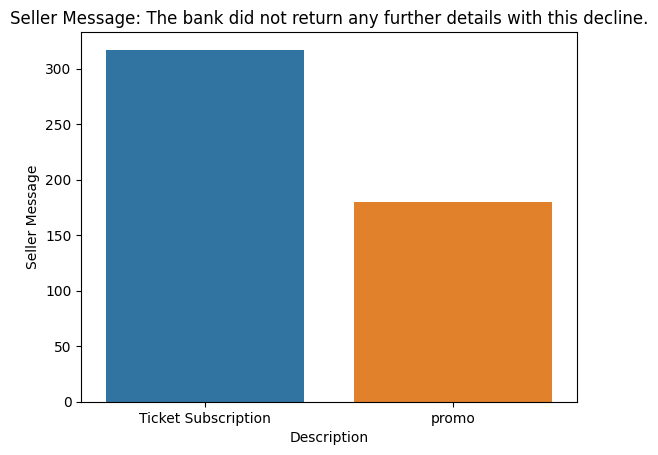

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription             396
promo                            31


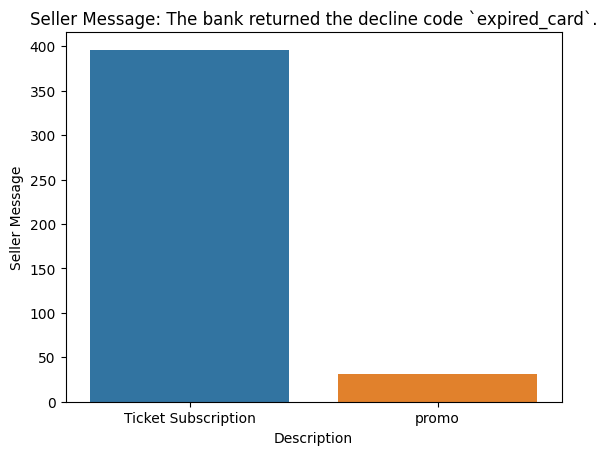

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription              41
datapack                          2
promo                            10


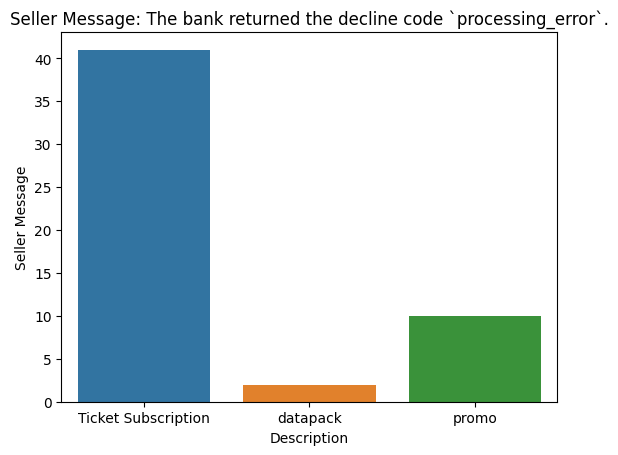

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription             508
datapack                          3
promo                             5


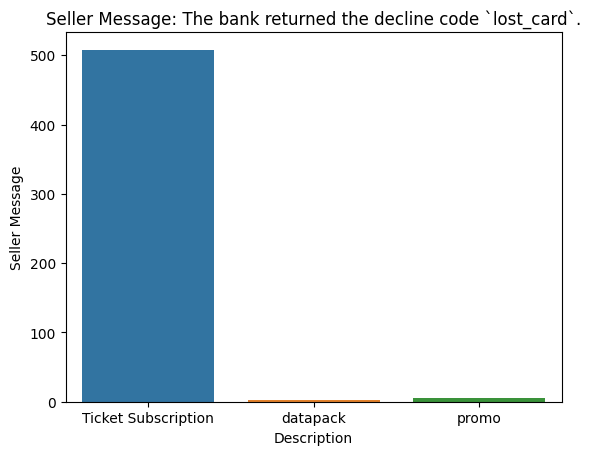

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription              21
promo                            11


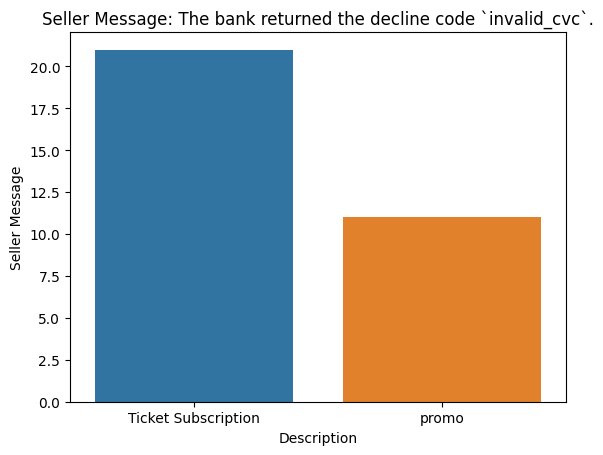

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription             224
datapack                         78
promo                           262


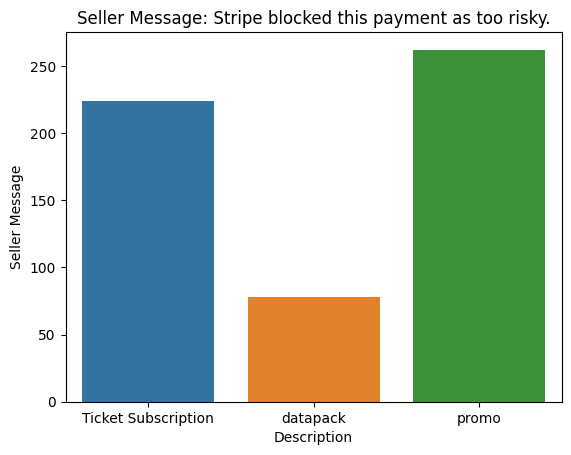

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription               7
promo                            45


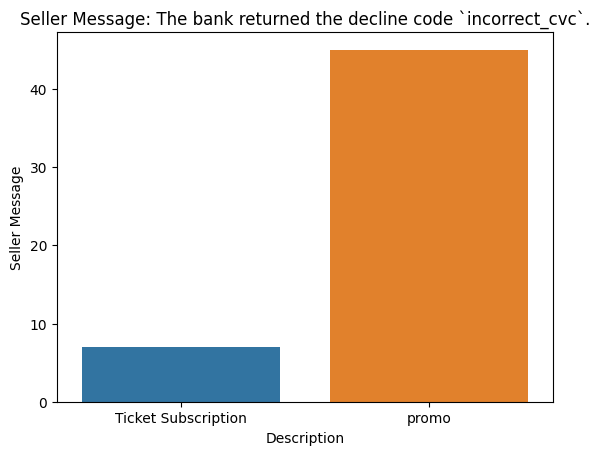

Values by Description for the following Seller Message: Payment complete.
              Seller Message
Description                
datapack                  2
promo                   133


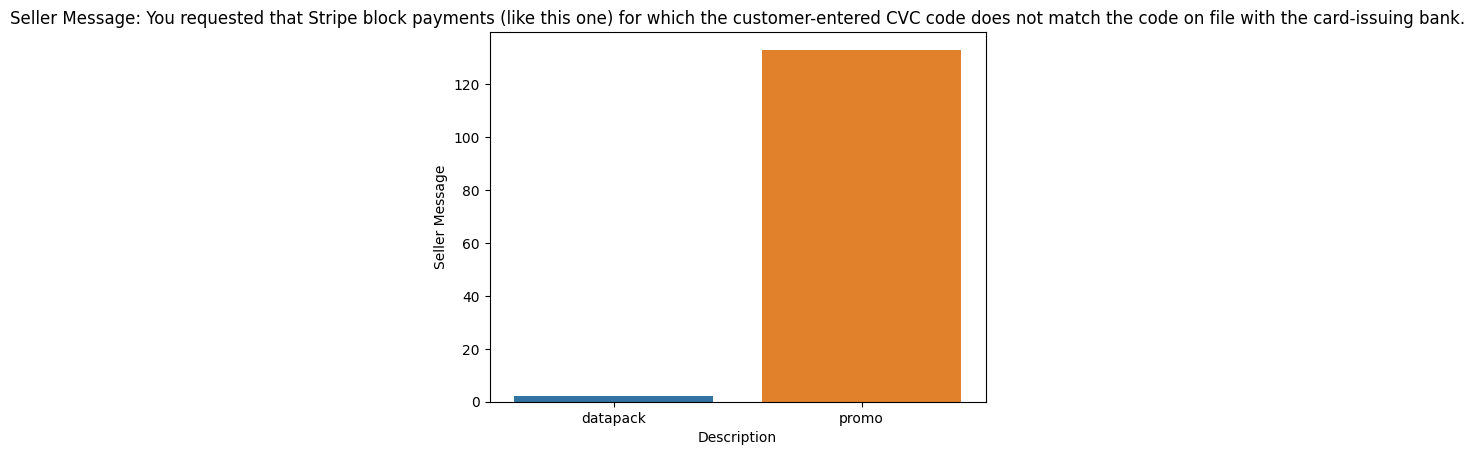

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription              24
promo                             1


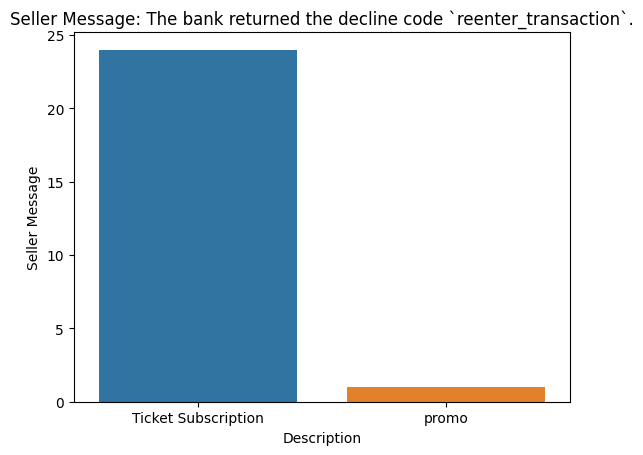

Values by Description for the following Seller Message: Payment complete.
              Seller Message
Description                
promo                     2


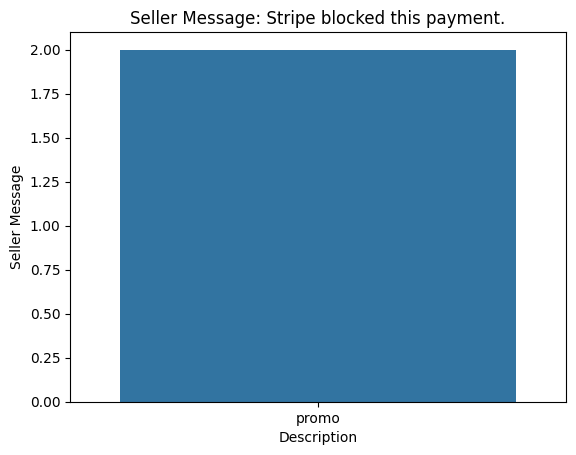

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription              91
promo                            36


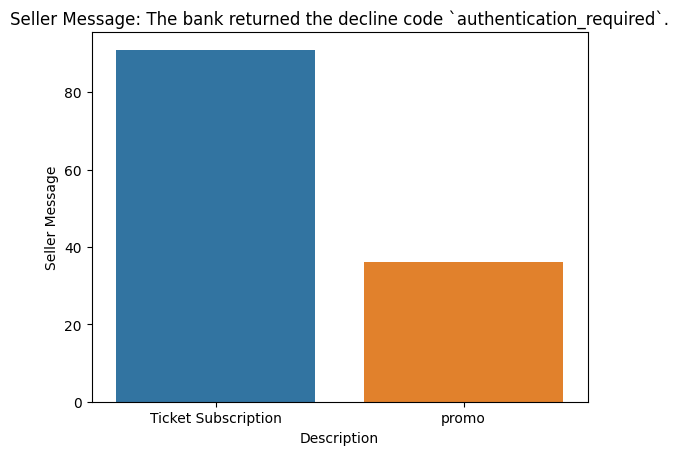

Values by Description for the following Seller Message: Payment complete.
                      Seller Message
Description                        
Ticket Subscription              10
promo                             3


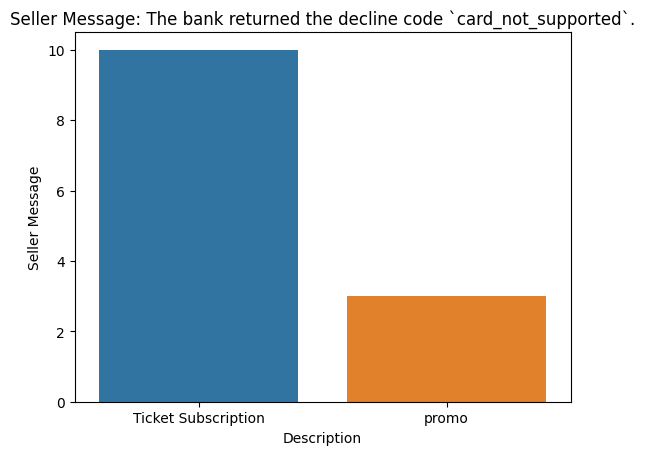

In [14]:
# check description vs seller message

# reuse code from above

for message in messages:

       # filter all data by only entries with this particular seller message
       filteredData = data[data['Seller Message'] == message]

       # split into different card fundings
       cardFunds = filteredData.groupby('Description')

       # output counts per card funding
       print("Values by Description for the following Seller Message:",messages[0] + "\n", cardFunds['Seller Message'].count().to_frame())

       # plot
       sns.barplot(x = cardFunds['Seller Message'].count().index, y = cardFunds['Seller Message'].count())
       plt.title('Seller Message: ' + message)
       plt.show()

# definitely some correlations here too
# perhaps non linear but it seems like both card fund and description can impact the seller message

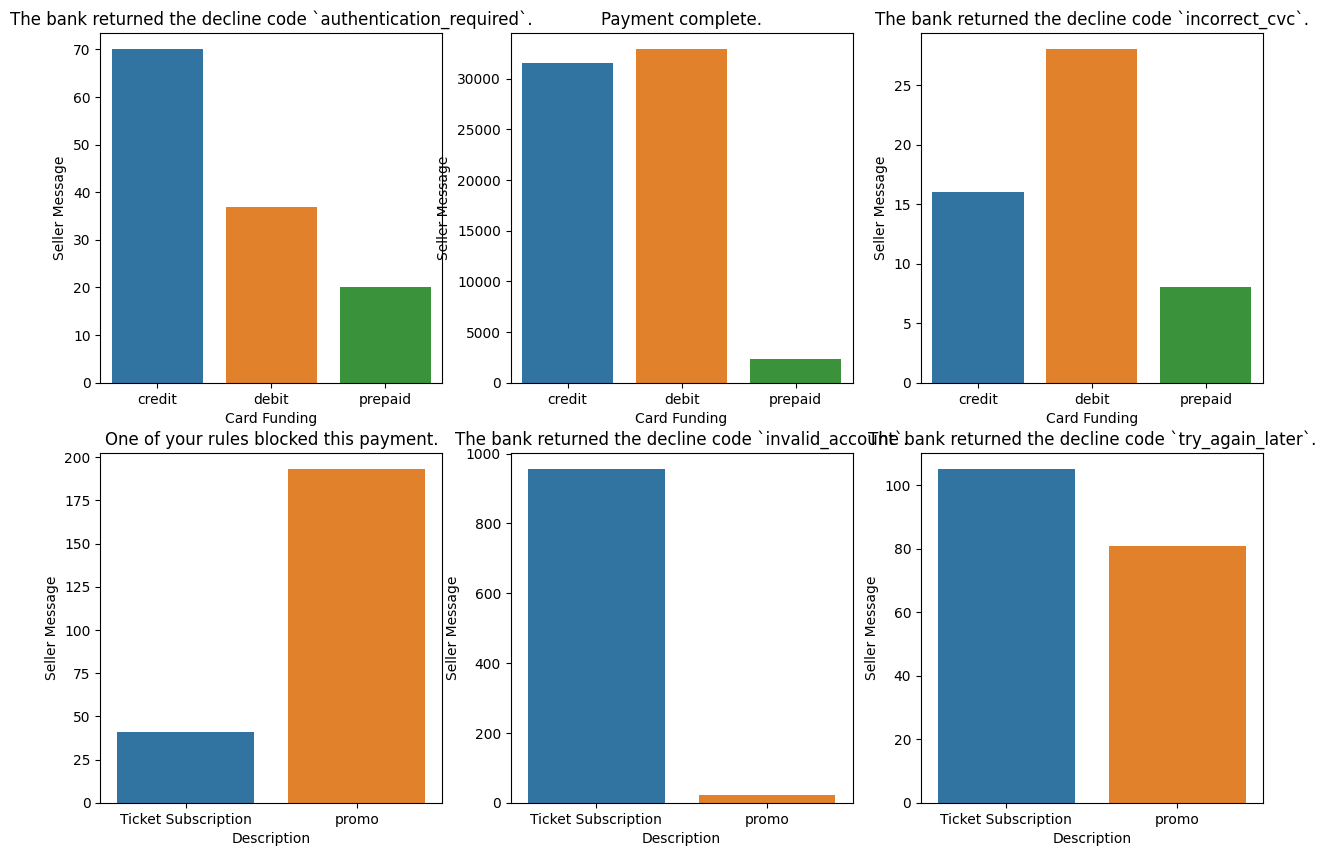

In [15]:
### cell to print output plots for the report

m1='The bank returned the decline code `authentication_required`.'

m2='Payment complete.'

m3='The bank returned the decline code `incorrect_cvc`.'

m4='One of your rules blocked this payment.'

m5='The bank returned the decline code `invalid_account`.'

m6='The bank returned the decline code `try_again_later`.'

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(15,10))


# filter all data by only entries with this particular seller message
filteredData = data[data['Seller Message'] == m1]
# split into different card fundings
cardFunds = filteredData.groupby('Card Funding')
# plot
sns.barplot(x = cardFunds['Seller Message'].count().index, y = cardFunds['Seller Message'].count(), ax=ax1,)
ax1.title.set_text(m1)


# filter all data by only entries with this particular seller message
filteredData = data[data['Seller Message'] == m2]
# split into different card fundings
cardFunds = filteredData.groupby('Card Funding')
# plot
sns.barplot(x = cardFunds['Seller Message'].count().index, y = cardFunds['Seller Message'].count(), ax=ax2,)
ax2.title.set_text(m2)

# filter all data by only entries with this particular seller message
filteredData = data[data['Seller Message'] == m3]
# split into different card fundings
cardFunds = filteredData.groupby('Card Funding')
# plot
sns.barplot(x = cardFunds['Seller Message'].count().index, y = cardFunds['Seller Message'].count(), ax=ax3,)
ax3.title.set_text(m3)


# filter all data by only entries with this particular seller message
filteredData = data[data['Seller Message'] == m4]
# split into different card fundings
cardFunds = filteredData.groupby('Description')
# plot
sns.barplot(x = cardFunds['Seller Message'].count().index, y = cardFunds['Seller Message'].count(), ax=ax4)
ax4.title.set_text(m4)

# filter all data by only entries with this particular seller message
filteredData = data[data['Seller Message'] == m5]
# split into different card fundings
cardFunds = filteredData.groupby('Description')
# plot
sns.barplot(x = cardFunds['Seller Message'].count().index, y = cardFunds['Seller Message'].count(), ax=ax5)
ax5.title.set_text(m5)

# filter all data by only entries with this particular seller message
filteredData = data[data['Seller Message'] == m6]
# split into different card fundings
cardFunds = filteredData.groupby('Description')
# plot
sns.barplot(x = cardFunds['Seller Message'].count().index, y = cardFunds['Seller Message'].count(), ax=ax6)
ax6.title.set_text(m6)

### Feature Engineering

Key Points:

* The seller message column initially contained about 23 unique messages. This was reduced to 6 classes of messages, user error, bank decline, admin error, blocked, stripe decline and payment completed.

* The seller message was also further broken down into a binary classification, 1 representing a seller message that may be concerning to the company and 0 representing a seller message that is not concerning to the company

* Create Date was also broken down into its constituent parts of Month, Day and Year

In [16]:
# group seller messages into generic bins


userError = ['The bank returned the decline code `insufficient_funds`.',
 'The bank returned the decline code `authentication_required`.',
 'The bank returned the decline code `incorrect_number`.',
       'The bank returned the decline code `invalid_account`.',
       'The bank returned the decline code `pickup_card`.',
  'The bank returned the decline code `expired_card`.',
       'The bank returned the decline code `lost_card`.',
       'The bank returned the decline code `invalid_cvc`.',
             'The bank returned the decline code `incorrect_cvc`.']
adminError = ['The bank returned the decline code `try_again_later`.',
     'The bank returned the decline code `reenter_transaction`.',
       'Stripe blocked this payment.',
       'The bank returned the decline code `card_not_supported`.',
       'The bank did not return any further details with this decline.',
       'The bank returned the decline code `processing_error`.']
bankDecline = ['The bank returned the decline code `transaction_not_allowed`.',
       'The bank returned the decline code `do_not_honor`.',
       'The bank returned the decline code `stolen_card`.']
processorDecline = ["You previously attempted to charge this card. When the customer's bank declined that payment, it directed Stripe to block future attempts.",
 'Stripe blocked this payment as too risky.']
blocked = ['One of your rules blocked this payment.',
            'You requested that Stripe block payments (like this one) for which the customer-entered CVC code does not match the code on file with the card-issuing bank.']


# filter function
def greatFilter(record):
     
     response = record['Seller Message']          
     
     if response in userError:
                         
          return 'User Error'
          
     elif response in adminError:
                         
          return 'Admin Error'
                         
     elif response in bankDecline:
                                
          return 'Bank Decline'
                    
     elif response in processorDecline:
               
          return 'Processor Decline'
                         
     elif response in blocked:

          return 'Blocked'
     
     else:
          
          return 'Payment Complete'
          
# create column to store generalized seller messages with filter function
data['General Seller Message'] = data.apply(greatFilter, axis=1)

# check if it worked
data['General Seller Message'].unique()


array(['Payment Complete', 'Bank Decline', 'User Error', 'Admin Error',
       'Blocked', 'Processor Decline'], dtype=object)

In [17]:
# further data engineering

# creating a binary output for whether or not a seller message means something that may be potentially concerning for the business or not

def into_concern_group(message_group):
    if message_group == 'Bank Decline':
        return  1
    elif message_group == 'Processor Decline':
        return  1
    else:
        return 0

data['concern_group'] = data['General Seller Message'].apply(into_concern_group)

# split the date column into constituent parts
data['Sale Date'] = pd.to_datetime(data['Created (UTC)'])
data['Year'] = data['Sale Date'].dt.year
data['Month'] = data['Sale Date'].dt.month
data['Day'] = data['Sale Date'].dt.day

### Modelling

3 Models were tested:

* A Logistic Regression

* KNN

* Decision Tree Classifier

Each of these models will be described and displayed below.

### Logistic Regression

In [18]:
# create data pipeline for logistic regression
catFeatures = ['Description', 'Status', 'Card Brand', 'Card Funding', 'Card Address City', 'Card Address State', 'Card Address Country', 'Card Issue Country', 'Amount', 'Year', 'Month', 'Day']
target = ['concern_group']

# train and test set
x_train, x_test, y_train, y_test = train_test_split(data[catFeatures], data[target], test_size=0.3, random_state=1)

# build pipeline, transformers
# apply one hot encoding
catTransformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])

# build preprocessor
preprocessor = ColumnTransformer(transformers = [('cat', catTransformer, catFeatures)])

# create logistic regression model in pipeline
logRegress = Pipeline(steps = [('preprocessor', preprocessor), ('log', LogisticRegression(random_state=1))])

# fit model
logRegress.fit(x_train, y_train)

# predictions
pred = logRegress.predict(x_test)

# performance metrics
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, pred, average='weighted')
print("Precision:", precision)

recall = recall_score(y_test, pred, average='weighted')
print("Recall Score:", recall)

f1 = f1_score(y_test, pred, average='weighted')
print("F1 Score:", f1)

# very high accuracies, may be indicating overfitting

c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9522481189209029
Precision: 0.9505927900406034
Recall Score: 0.9522481189209029
F1 Score: 0.951143008592027


c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
# hyper parameter tuning

### This cell takes 8 mins to run

# now that we have baseline scores we can perform a random search to tune hyper parameters

# repeat some steps of pipeline from previous cell

# create classifier
logRegress = Pipeline(steps = [('preprocessor', preprocessor), ('log', LogisticRegression(random_state=1))])

# create dictionary of parameters, using __ notation to match the named pipeline step

params = {
    'log__penalty': ['l1', 'l2'],
    'log__fit_intercept': [True, False],
    'log__solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'log__max_iter': [50, 100, 200]
}

# create grid search, pass in the tree by named step in the pipeline and the parameter dictionary
# random search will also perform cross validation using StratifiedKFold
gridSearch = RandomizedSearchCV(logRegress, params, n_iter=25)

# perform fit
gridSearch.fit(x_train, y_train)

# grab best params
bestParams = gridSearch.best_params_
print("Best Params:", bestParams)

c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataC

Best Params: {'log__solver': 'newton-cg', 'log__penalty': 'l2', 'log__max_iter': 100, 'log__fit_intercept': True}


In [20]:
# create model with best parameters

# logistic regression
logRegress = Pipeline(steps = [('preprocessor', preprocessor), ('log', LogisticRegression(solver='newton-cg', penalty='l2', max_iter=100, fit_intercept=True, random_state=1))])

# fit model
logRegress.fit(x_train, y_train)

# predictions
pred = logRegress.predict(x_test)

# performance metrics
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, pred, average='weighted')
print("Precision:", precision)

recall = recall_score(y_test, pred, average='weighted')
print("Recall Score:", recall)

f1 = f1_score(y_test, pred, average='weighted')
print("F1 Score:", f1)

# very high accuracies, may be indicating overfitting

c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9529087906037805
Precision: 0.9513010933313837
Recall Score: 0.9529087906037805
F1 Score: 0.9518340187338268


In [21]:
# cross validation

crossVal = cross_val_score(logRegress, x_train, y_train, cv=5, scoring='accuracy')

# print scores
print("Cross Validation Accuracies:", crossVal)

# slightly lower accuracies for cross validation, may indicate over fitting

c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataC

Cross Validation Accuracies: [0.9498191  0.94690892 0.9498191  0.94596508 0.94934718]


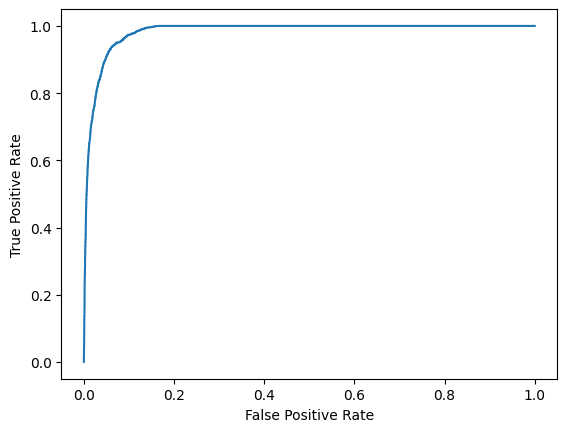

0.2409075068877124
0.9386714752464277


In [22]:
yhat_log = logRegress.predict_proba(x_test)

# creating roc curve
fpr, tpr, thresholds = roc_curve(y_test, yhat_log[:,1])

plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# geometric means
gmeans = np.sqrt(tpr*(1-fpr))
print(thresholds[np.argmax(gmeans)])
print(gmeans[np.argmax(gmeans)])

In [23]:
# Set the threshold for conversion
threshold = 0.3

# Define a custom function to convert each inner array into a single value based on the threshold
def convert_inner_array(arr):
    return 1 if np.any(arr >= threshold) else 0

# Apply the custom function to each inner array using np.apply_along_axis()
converted_array = np.apply_along_axis(convert_inner_array, axis=1, arr=yhat_log)

print(converted_array)

print("F1: ", f1_score(y_test,converted_array))
print("precision: ", precision_score(y_test,converted_array))
print("recall: ", recall_score(y_test,converted_array))
print("accuracy: ", accuracy_score(y_test,converted_array))

[1 1 1 ... 1 1 1]
F1:  0.20265857439720286
precision:  0.11275463387777573
recall:  1.0
accuracy:  0.11275463387777573


# Conclusions for Logistic Regression

This model has a very low precision, accuracy, and f1 score. Furthermore the perfect recall is somewhat concerning.

# KNN

In [24]:
### this cell takes about 4 minutes to run

# build data pipeline
catFeatures = ['Description', 'Status', 'Card Brand', 'Card Funding', 'Card Address City', 'Card Address State', 'Card Address Country', 'Card Issue Country', 'Amount', 'Year', 'Month', 'Day']
target = ['General Seller Message']

# train and test set
x_train, x_test, y_train, y_test = train_test_split(data[catFeatures], data[target], test_size=0.3, random_state=1)

# build pipeline, transformers
# apply one hot encoding
catTransformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])

# build preprocessor
preprocessor = ColumnTransformer(transformers = [('cat', catTransformer, catFeatures)])

# create knn
knn = Pipeline(steps = [('preprocessor', preprocessor), ('knn', KNeighborsClassifier())])

# fit model
knn.fit(x_train, y_train)

# predictions
pred = knn.predict(x_test)

# performance metrics
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, pred, average='weighted')
print("Precision:", precision)

recall = recall_score(y_test, pred, average='weighted')
print("Recall Score:", recall)

f1 = f1_score(y_test, pred, average='weighted')
print("F1 Score:", f1)

# note these are very high accuracies, might be indicating potential overfitting
# will follow this up with hyper-parameter tuning and cross validation

c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.9336391998531841
Precision: 0.9305680327719138
Recall Score: 0.9336391998531841
F1 Score: 0.9316175443414146


In [25]:
### this cell takes 20 mins to run

# hyper parameter tuning

# now that we have baseline scores we can perform a random search to tune hyper parameters

# repeat some steps of pipeline from previous cell

# create classifier
knn = Pipeline(steps = [('preprocessor', preprocessor), ('knn', KNeighborsClassifier())])

# create dictionary of parameters, using __ notation to match the named pipeline step

params = {
    'knn__n_neighbors': [5,10,15,20,25,30],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [30, 40, 50, 60],
    'knn__p' : [1,2]
}

# create grid search, pass in the tree by named step in the pipeline and the parameter dictionary
# random search will also perform cross validation using StratifiedKFold
gridSearch = RandomizedSearchCV(knn, params, n_iter=25)

# perform fit
gridSearch.fit(x_train, y_train)

# grab best params
bestParams = gridSearch.best_params_
print(bestParams)

c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_base.py:557: UserWarning: cannot use tree with sparse input: using brute fo

{'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 5, 'knn__leaf_size': 40, 'knn__algorithm': 'ball_tree'}


c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


In [26]:
# create model with the best params

# create knn
knn = Pipeline(steps = [('preprocessor', preprocessor), ('knn', KNeighborsClassifier(weights='distance', p=1, n_neighbors=5, leaf_size=40, algorithm='kd_tree'))])

# fit model
knn.fit(x_train, y_train)

# predictions
pred = knn.predict(x_test)

# performance metrics
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, pred, average='weighted')
print("Precision:", precision)

recall = recall_score(y_test, pred, average='weighted')
print("Recall Score:", recall)

f1 = f1_score(y_test, pred, average='weighted')
print("F1 Score:", f1)

# better performance than the base model
# however this performance is so good that overfitting might have occurred

c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


Accuracy: 0.9466324096164433
Precision: 0.9449054655863325
Recall Score: 0.9466324096164433
F1 Score: 0.9455198646397248


In [27]:
# cross validation

crossVal = cross_val_score(knn, x_train, y_train, cv=5, scoring='accuracy')

# print scores
print("Cross Validation Accuracies:", crossVal)

# accuracies are nearly identical to the one from the training set

c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_base.py:557: UserWarning: cannot use tree with sparse input: using brute fo

Cross Validation Accuracies: [0.94077395 0.93983011 0.94415605 0.94030203 0.94163914]


### Conclusions for KNN

This model does perform well. After cross validation its cross validation accuracies are nearly identical the accuracy acheived on the training set. Its performance is very similar to that of the decision tree below.

### Random Forest

In [28]:
### this cell takes about 4 minutes to run

# build data pipeline
catFeatures = ['Description', 'Status', 'Card Brand', 'Card Funding', 'Card Address City', 'Card Address State', 'Card Address Country', 'Card Issue Country', 'Amount', 'Year', 'Month', 'Day']
target = ['General Seller Message']

# train and test set
x_train, x_test, y_train, y_test = train_test_split(data[catFeatures], data[target], test_size=0.3, random_state=1)

# build pipeline, transformers
# apply one hot encoding
catTransformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])

# build preprocessor
preprocessor = ColumnTransformer(transformers = [('cat', catTransformer, catFeatures)])

# create random forest
randForest = Pipeline(steps = [('preprocessor', preprocessor), ('forest', RandomForestClassifier(random_state=1))])

# fit model
randForest.fit(x_train, y_train)

# predictions
pred = randForest.predict(x_test)

# performance metrics
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, pred, average='weighted')
print("Precision:", precision)

recall = recall_score(y_test, pred, average='weighted')
print("Recall Score:", recall)

f1 = f1_score(y_test, pred, average='weighted')
print("F1 Score:", f1)

# note these are very high accuracies, might be indicating potential overfitting
# will follow this up with hyper-parameter tuning and cross validation

c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Accuracy: 0.9670031198385025
Precision: 0.9661471627067311
Recall Score: 0.9670031198385025
F1 Score: 0.9661620423507943


In [29]:
### This cell takes 20 mins to run

# now that we have baseline scores we can perform a random search to tune hyper parameters

# repeat some steps of pipeline from previous cell

# create classifier
randForest = Pipeline(steps = [('preprocessor', preprocessor), ('forest', RandomForestClassifier(random_state=1))])

# create dictionary of parameters, using __ notation to match the named pipeline step

params = {
    'forest__criterion': ['gini', 'entropy', 'log_loss'],
    'forest__max_depth': [5, 20, 30],
    'forest__min_samples_split': [2, 4, 8, 10],
    'forest__min_samples_leaf': [1, 2, 4, 5],
    'forest__n_estimators' : [50, 100, 200]
}

# create grid search, pass in the tree by named step in the pipeline and the parameter dictionary
# random search will also perform cross validation using StratifiedKFold
gridSearch = RandomizedSearchCV(randForest, params, n_iter=50)

# perform fit
gridSearch.fit(x_train, y_train)

# grab best params
bestParams = gridSearch.best_params_
print(bestParams)

c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-

{'forest__n_estimators': 50, 'forest__min_samples_split': 2, 'forest__min_samples_leaf': 2, 'forest__max_depth': 30, 'forest__criterion': 'gini'}


In [30]:
# create model with best parameters
randForest = Pipeline(steps = [('preprocessor', preprocessor), ('forest', RandomForestClassifier(n_estimators=50, min_samples_split=4, min_samples_leaf=1, max_depth=30, criterion='gini', random_state=1))])

# fit model
randForest.fit(x_train, y_train)

# run predictions
pred = randForest.predict(x_test)

# metrics
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, pred, average='weighted')
print("Precision:", precision)

recall = recall_score(y_test, pred, average='weighted')
print("Recall Score:", recall)

f1 = f1_score(y_test, pred, average='weighted')
print("F1 Score:", f1)

# actually a lower value than the model with default parameters
# perhaps it is because the original model was overfit, and would perform poorly in cross validation

# given that grid search does perform cross validation, that may be why it selected this as the best parameter set

c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Accuracy: 0.7697926224995412
Precision: 0.8010758093317216
Recall Score: 0.7697926224995412
F1 Score: 0.6935517828545246


In [31]:
# perform cross validation

crossVal = cross_val_score(randForest, x_train, y_train, cv=5, scoring='accuracy')

# print scores
print("Cross Validation Accuracies:", crossVal)

# acheived higher accruacies accross the board than the best parameter model
# this might be signifying data leakage, model may have become specialized to training data

# the data imbalance in the seller message (target variable) may play into this too
# it is worth nothing that the accruacy of the model is 70%, and 'Payment Complete' does make up about 70% of the data

# a potential solution / next step: drop records that have 'Payment Complete' until it somewhat matches the amount of other seller messages
# we actually might have enough data to do this or we might need more data, not sure off the top of my head

c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-

Cross Validation Accuracies: [0.7791411  0.81201825 0.79086047 0.81964763 0.86833412]


In [32]:
# print out classification report and confusion matrix for further statistics on best parameter model

# Making the Confusion Matrix
print(confusion_matrix(y_test, pred))

# Printing the classification report
print(classification_report(y_test, pred))

[[    4     0     0   257     2     0]
 [    0   153     0  2434     9    52]
 [    0     0     2   101     0     0]
 [    0     0     0 20146     0     0]
 [    0     8     0   358    50     8]
 [    0     5     2  3030     6   618]]
                   precision    recall  f1-score   support

      Admin Error       1.00      0.02      0.03       263
     Bank Decline       0.92      0.06      0.11      2648
          Blocked       0.50      0.02      0.04       103
 Payment Complete       0.77      1.00      0.87     20146
Processor Decline       0.75      0.12      0.20       424
       User Error       0.91      0.17      0.28      3661

         accuracy                           0.77     27245
        macro avg       0.81      0.23      0.26     27245
     weighted avg       0.80      0.77      0.69     27245



- Confusion Matrix: It shows the correct predictions (the diagonal from top-left to bottom-right) and the types of incorrect predictions made. Since our model has nearly perfect accuracy, all values off the diagonal are zeros, indicating no misclassifications.

- Classification Report: It provides the precision, recall, f1-score and support for each class.

- Precision: The model has an excellent precision score, which means that it is highly accurate when it predicts a certain class, there are very few false positives.

- Recall: The model also has a high recall, which means that it correctly identified most of the positive cases, there are very few false negatives.

- F1-Score: This is a harmonic mean of Precision and Recall, and it tries to find the balance between these two metrics. A high F1-score indicates a robust model.

- Accuracy: This is the total accuracy of the model.

### Conclusion of Random Forest

This model does perform reasonably well, it has a decent accuracy but a slightly lower f1 score. One point of concern is that the cross validation accuracies are lower than the accuracy on the testing set, this could be indicative some overfitting, though a random forest should be somewhat less susceptble to overfitting than other models.

### Decision Tree

c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_export.py:676: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from current font.
  ann.update_bbox_position_size(renderer)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_export.py:676: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  ann.update_bbox_position_size(renderer)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_export.py:676: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from current font.
  ann.update_bbox_position_size(renderer)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_export.py:676: UserWarning: Glyph 31070 (\N{CJK UNIFIED IDEOGRAPH-795E}) missing from current font.
  ann.update_bbox_position_size(renderer)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_export.py:676: UserWar

Accuracy: 0.9602495870801983
Precision: 0.9596970860280394
Recall Score: 0.9602495870801983
F1 Score: 0.9599142181852054


C:\Users\darre\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31070 (\N{CJK UNIFIED IDEOGRAPH-795E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\darre\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22856 (\N{CJK UNIFIED IDEOGRAPH-5948}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\darre\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24029 (\N{CJK UNIFIED IDEOGRAPH-5DDD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\darre\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30476 (\N{CJK UNIFIED IDEOGRAPH-770C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\darre\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 442

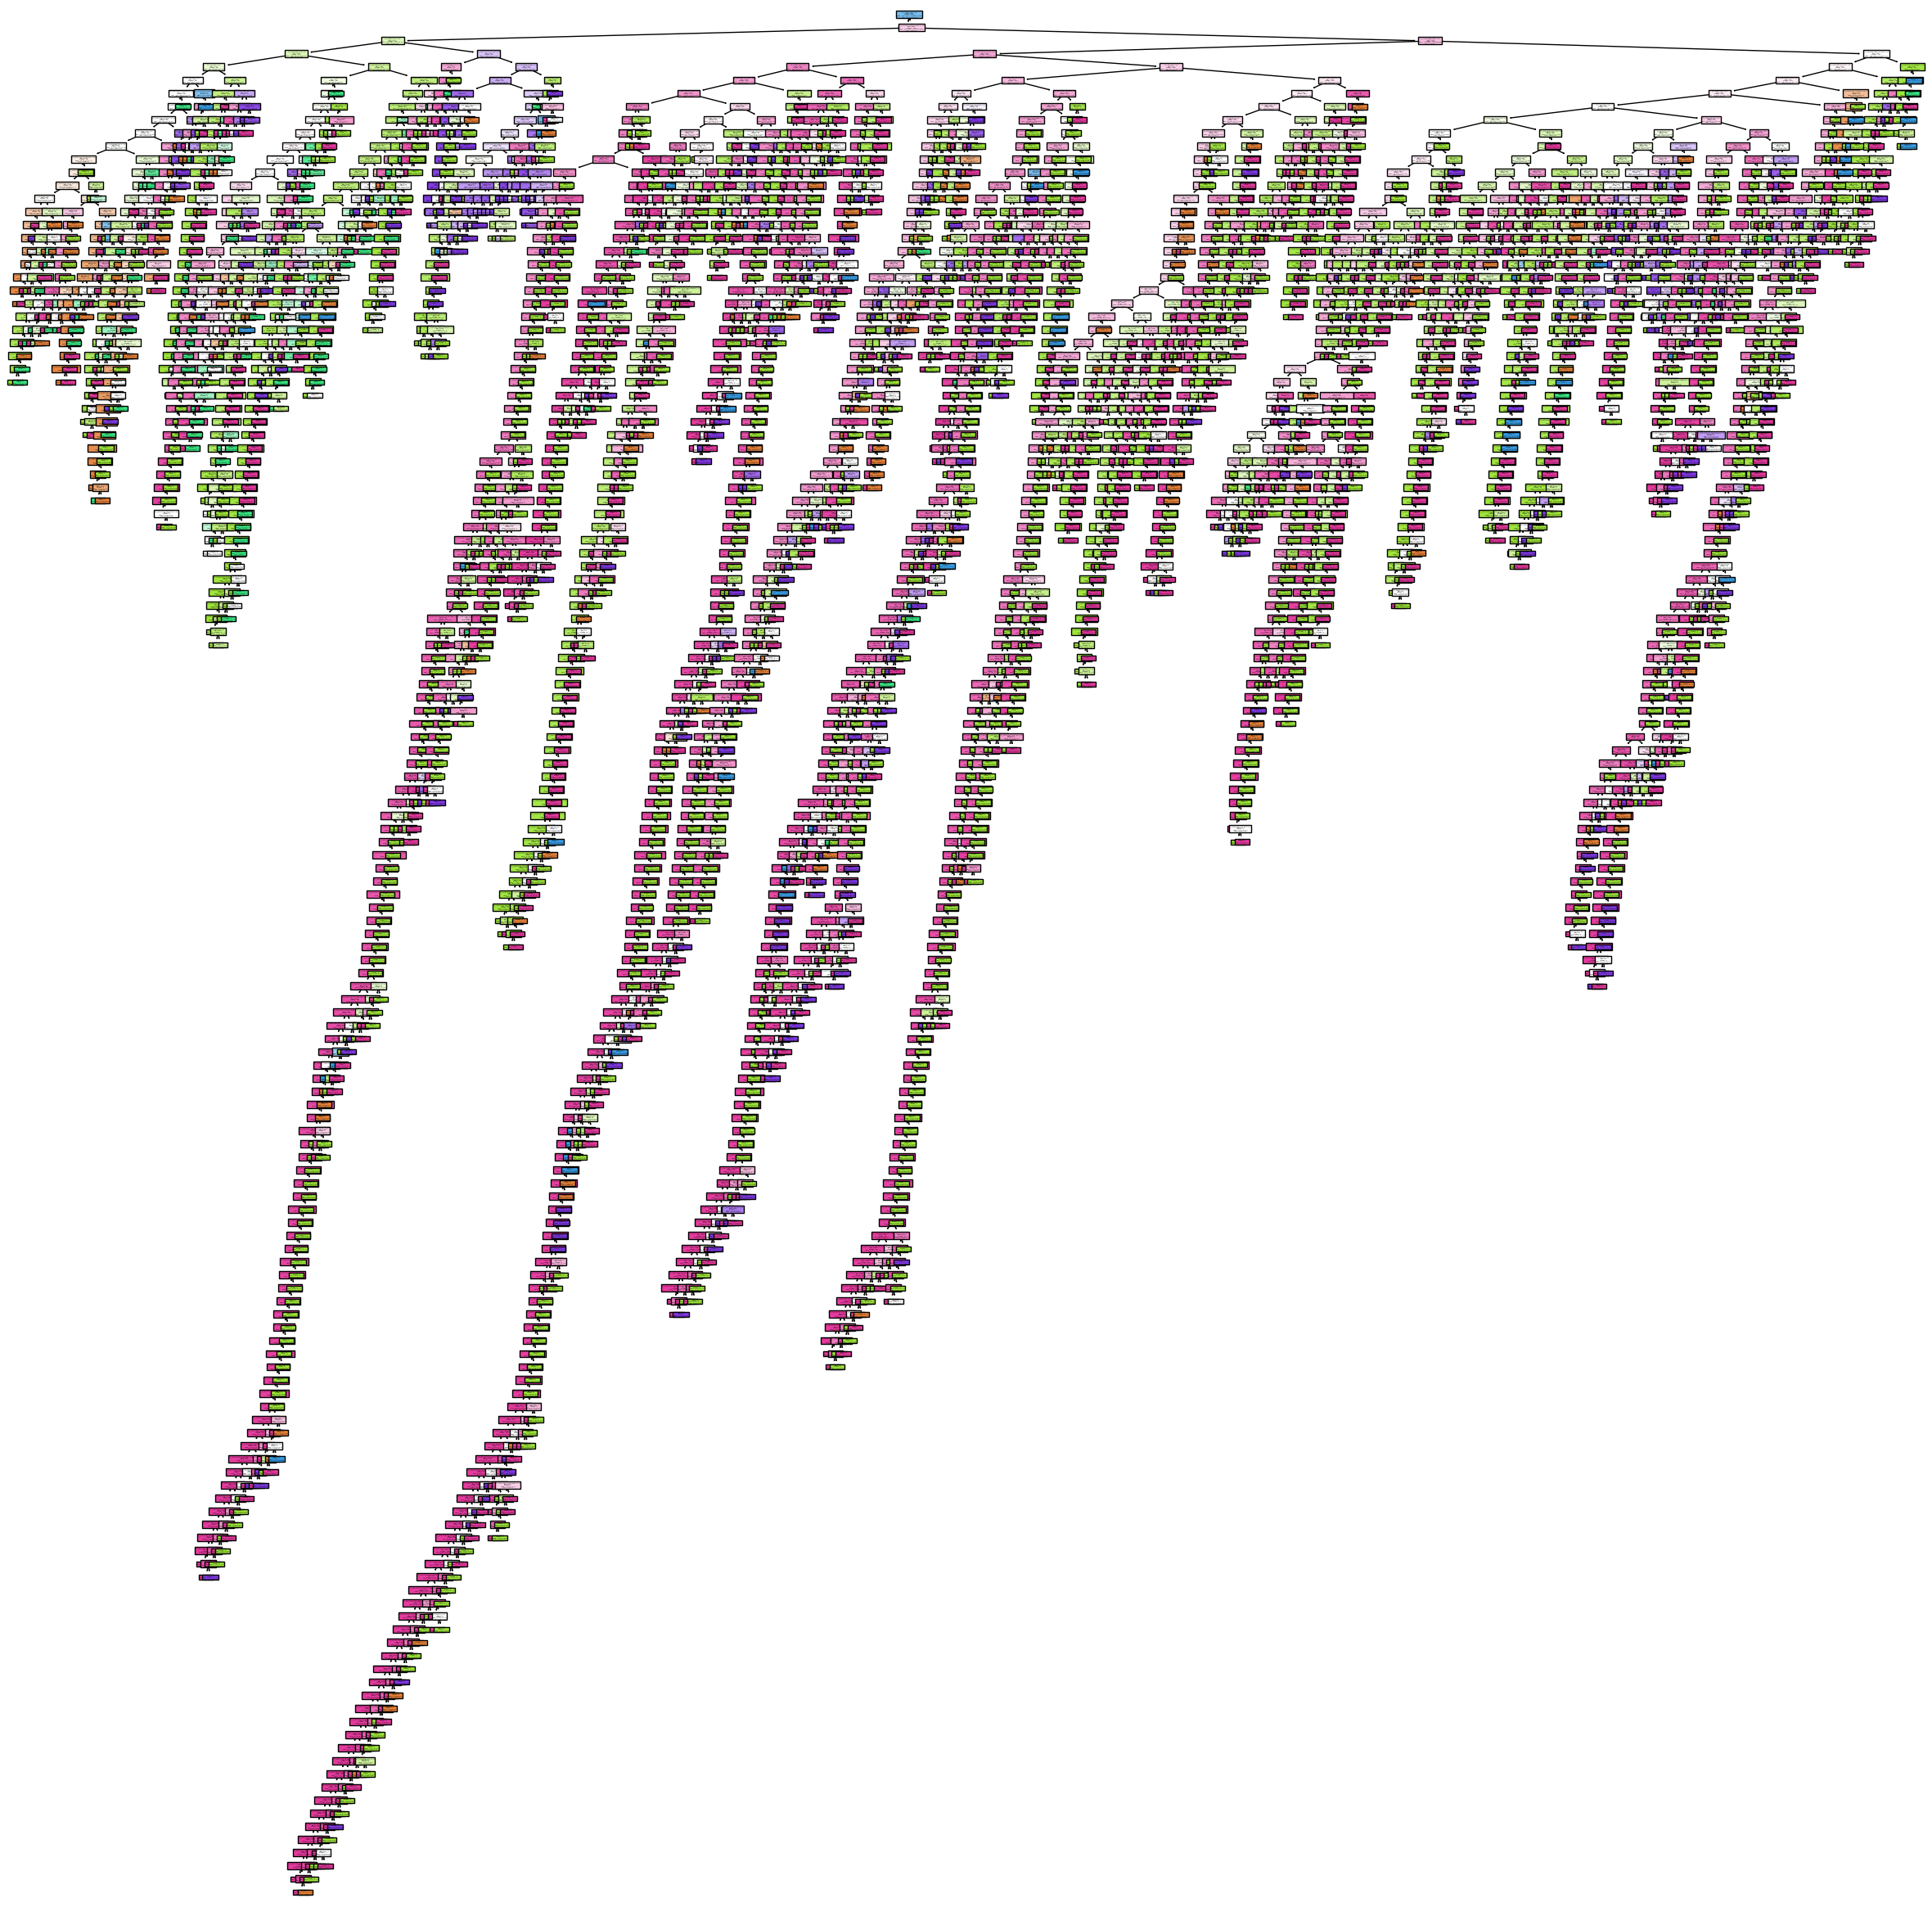

In [33]:
# now begin testing a decision tree model

### this cell takes about 3 mins to run

# can use this to also check how relevant a feature is
# limiting the depth of the tree will show what features it flags as most important

# will need to onehot encode the categorical input features

# will build a max depth tree to check what features are most relevant to begin

catFeatures = ['Description', 'Status', 'Card Brand', 'Card Funding', 'Card Address City', 'Card Address State', 'Card Address Country', 'Card Issue Country', 'Amount', 'Year', 'Month', 'Day']
target = ['General Seller Message']

# train and test set
x_train, x_test, y_train, y_test = train_test_split(data[catFeatures], data[target], test_size=0.3, random_state=1)

# build pipeline, transformers
# apply one hot encoding
catTransformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])

# build preprocessor
preprocessor = ColumnTransformer(transformers = [('cat', catTransformer, catFeatures)])

# apply full tree (no depth limit) to begin with to select features
decTree = Pipeline(steps = [('preprocessor', preprocessor), ('tree', DecisionTreeClassifier(random_state=1))])

# fit model
decTree.fit(x_train, y_train)

# attempt to visualize output of tree
# SAVE FIGURE FOR BEST IMAGE
plt.figure(figsize=(30,30))
plot = plot_tree(decTree.named_steps['tree'], feature_names=list(decTree.named_steps['preprocessor'].get_feature_names_out()), class_names=list(decTree.named_steps['tree'].classes_), filled=True)
plt.savefig("tree.png", dpi=800)

# run predictions
pred = decTree.predict(x_test)

# metrics
# though don't care too mcuh about these metrics given that 

accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, pred, average='weighted')
print("Precision:", precision)

recall = recall_score(y_test, pred, average='weighted')
print("Recall Score:", recall)

f1 = f1_score(y_test, pred, average='weighted')
print("F1 Score:", f1)

In [34]:
# now check what features were most important in making decisions

# create dataframe with feature importance of all features
features = pd.DataFrame(decTree.named_steps['tree'].feature_importances_, index = decTree.named_steps['preprocessor'].get_feature_names_out(), columns = ['importance']).sort_values('importance', ascending=False)

# display all rows
pd.set_option('display.max_rows', None)

# grab descriptive stats
features.describe()
mean = 0.000086

# convert the index to a column for easier reference
features['feature'] = features.index

# check importances for some columns using string wilcards

# if a single category for the feature has an importance > mean, then that feature should remain
print("Status\n", features[features['feature'].str.contains('Status') & features['importance'] > mean].count())
print("Amount\n", features[features['feature'].str.contains('Amount') & features['importance'] > mean].count())
print("Brand\n", features[features['feature'].str.contains('Brand') & features['importance'] > mean].count())
print("Funding\n", features[features['feature'].str.contains('Funding') & features['importance'] > mean].count())
print("City\n", features[features['feature'].str.contains('City') & features['importance'] > mean].count())
print("State\n", features[features['feature'].str.contains('State') & features['importance'] > mean].count())
print("Address Country\n", features[features['feature'].str.contains('Address Country') & features['importance'] > mean].count())
print("Issue Country\n", features[features['feature'].str.contains('Issue Country') & features['importance'] > mean].count())
print("Year\n", features[features['feature'].str.contains('Year') & features['importance'] > mean].count())
print("Month\n", features[features['feature'].str.contains('Month') & features['importance'] > mean].count())
print("Day\n", features[features['feature'].str.contains('Day') & features['importance'] > mean].count())

# all input features have at least 1 category with an importance above the mean

# could try including card fingerprint
# or could increase threshold

Status
 importance    1
feature       1
dtype: int64
Amount
 importance    13
feature       13
dtype: int64
Brand
 importance    5
feature       5
dtype: int64
Funding
 importance    4
feature       4
dtype: int64
City
 importance    949
feature       949
dtype: int64
State
 importance    317
feature       317
dtype: int64
Address Country
 importance    42
feature       42
dtype: int64
Issue Country
 importance    39
feature       39
dtype: int64
Year
 importance    4
feature       4
dtype: int64
Month
 importance    12
feature       12
dtype: int64
Day
 importance    33
feature       33
dtype: int64


Accuracy: 0.8877959258579556
Precision: 0.8795668524208158
Recall Score: 0.8877959258579556


c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 Score: 0.8664239386861334


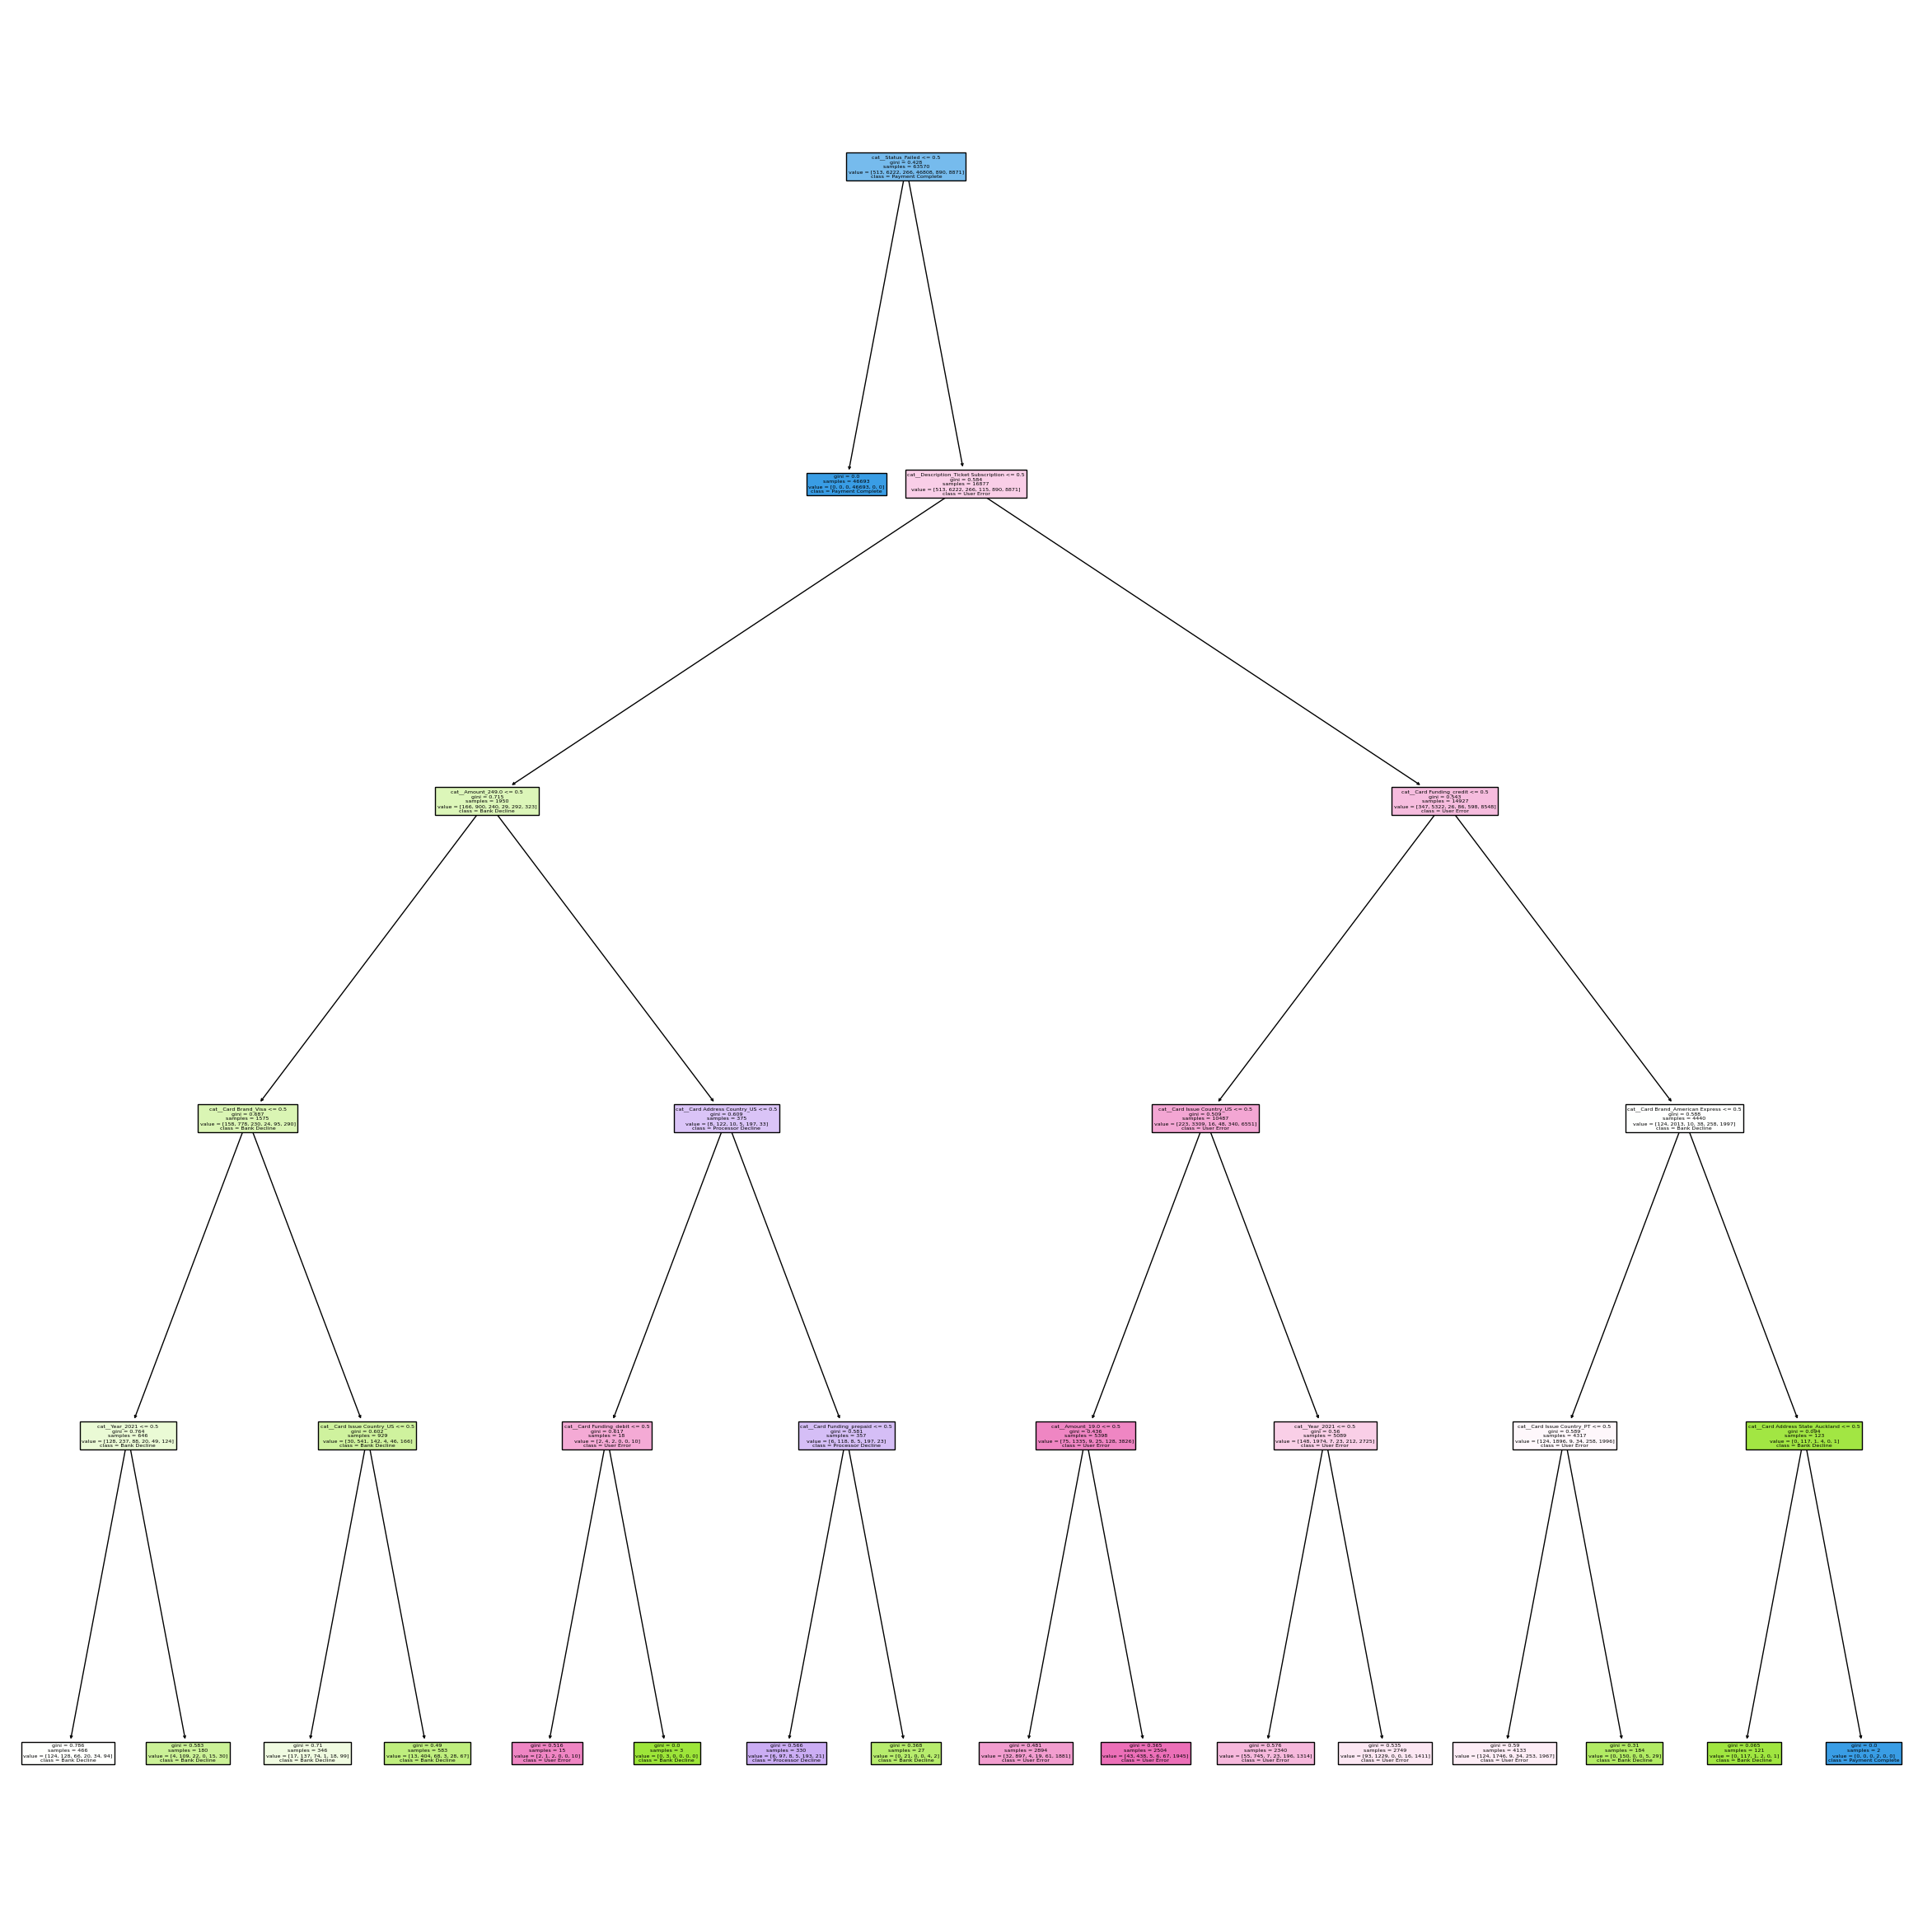

In [35]:
# from the above output we can see that each input feature did have some one of its categories with an importance greater than the mean importance of all features

# thus all features will be kept

# given that the list of input features is not overly large, (only about 11) this is acceptable

# now a thorough grid search will be used to test input parameters for the decision tree model

# but firstly a smaller tree will be tested just to get a baseline for performance metrics

# apply smaller tree to get a baseline
decTree = Pipeline(steps = [('preprocessor', preprocessor), ('tree', DecisionTreeClassifier(max_depth=5,random_state=1))])

# fit model
decTree.fit(x_train, y_train)

# attempt to visualize output of tree
# SAVE FIGURE FOR BEST IMAGE
plt.figure(figsize=(30,30))
plot = plot_tree(decTree.named_steps['tree'], feature_names=list(decTree.named_steps['preprocessor'].get_feature_names_out()), class_names=list(decTree.named_steps['tree'].classes_), filled=True)
plt.savefig("treeSmall.png", dpi=800)

# run predictions
pred = decTree.predict(x_test)

# metrics
# though don't care too mcuh about these metrics given that 

accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, pred, average='weighted')
print("Precision:", precision)
# precision is encountering a division by 0, not sure how, but will take this measurement with a grain of salt moving forward

recall = recall_score(y_test, pred, average='weighted')
print("Recall Score:", recall)

f1 = f1_score(y_test, pred, average='weighted')
print("F1 Score:", f1)

In [36]:
### This cell takes 26 mins to run

# now that we have baseline scores we can perform a gridsearch to tune hyper parameters

# repeat some steps of pipeline from previous cell

# create classifier
decTree = Pipeline(steps = [('preprocessor', preprocessor), ('tree', DecisionTreeClassifier(max_depth=5,random_state=1))])

# create dictionary of parameters, using __ notation to match the named pipeline step

params = {
    'tree__criterion': ['gini', 'entropy', 'log_loss'],
    'tree__max_depth': [5, 10, 15, 20, 25, 30],
    'tree__min_samples_split': [2, 4, 5, 6, 8, 10],
    'tree__min_samples_leaf': [1, 2, 4, 5]
}

# create grid search, pass in the tree by named step in the pipeline and the parameter dictionary
# grid search will also perform cross validation using StratifiedKFold
gridSearch = GridSearchCV(decTree, params)

# perform fit
gridSearch.fit(x_train, y_train)

# grab best params
bestParams = gridSearch.best_params_
print(bestParams)

{'tree__criterion': 'entropy', 'tree__max_depth': 30, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}


c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_export.py:676: UserWarning: Glyph 31070 (\N{CJK UNIFIED IDEOGRAPH-795E}) missing from current font.
  ann.update_bbox_position_size(renderer)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_export.py:676: UserWarning: Glyph 22856 (\N{CJK UNIFIED IDEOGRAPH-5948}) missing from current font.
  ann.update_bbox_position_size(renderer)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_export.py:676: UserWarning: Glyph 24029 (\N{CJK UNIFIED IDEOGRAPH-5DDD}) missing from current font.
  ann.update_bbox_position_size(renderer)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_export.py:676: UserWarning: Glyph 30476 (\N{CJK UNIFIED IDEOGRAPH-770C}) missing from current font.
  ann.update_bbox_position_size(renderer)
c:\Users\darre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tre

Accuracy: 0.9433657551844375
Precision: 0.9437116038081325
Recall Score: 0.9433657551844375
F1 Score: 0.9432224556741863


C:\Users\darre\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31070 (\N{CJK UNIFIED IDEOGRAPH-795E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\darre\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22856 (\N{CJK UNIFIED IDEOGRAPH-5948}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\darre\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24029 (\N{CJK UNIFIED IDEOGRAPH-5DDD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\darre\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30476 (\N{CJK UNIFIED IDEOGRAPH-770C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\darre\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 126

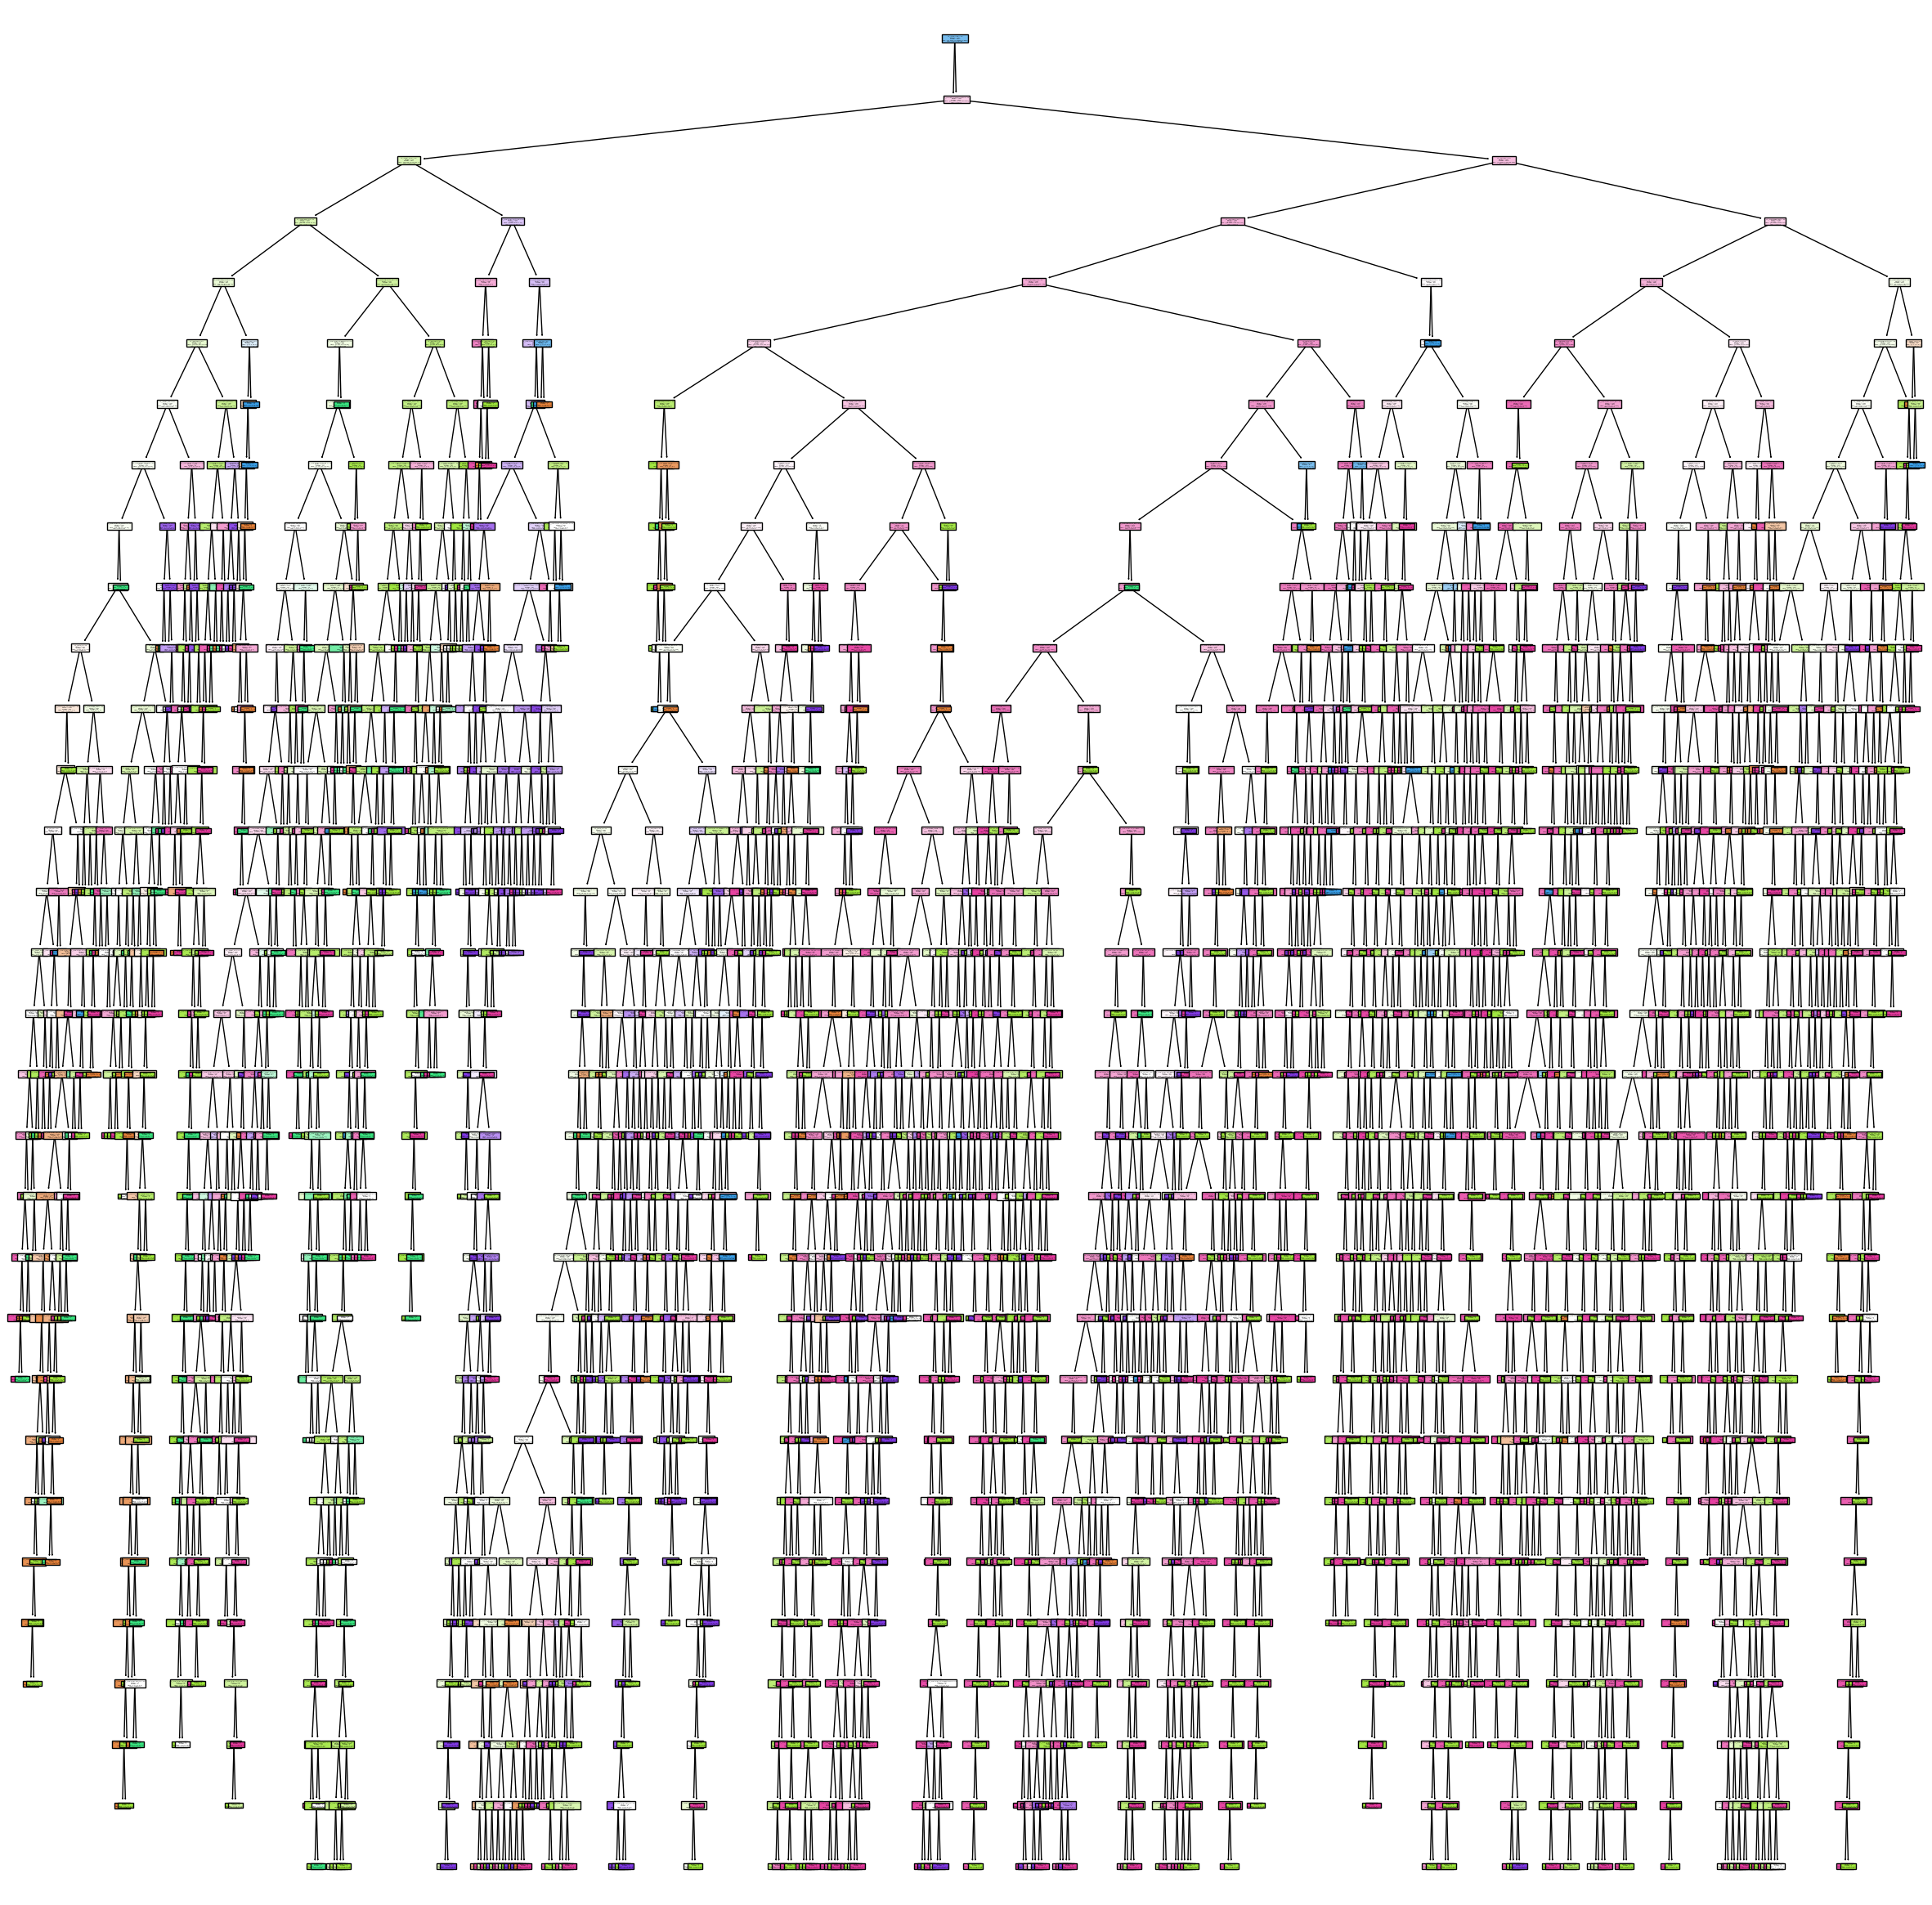

In [37]:
# create a decision tree using the returned best parameters and test its performance metrics
decTree = Pipeline(steps = [('preprocessor', preprocessor), ('tree', DecisionTreeClassifier(criterion='entropy', max_depth=30, min_samples_leaf=1, min_samples_split=2, random_state=1))])

# fit model
decTree.fit(x_train, y_train)

# attempt to visualize output of tree
# SAVE FIGURE FOR BEST IMAGE
plt.figure(figsize=(30,30))
plot = plot_tree(decTree.named_steps['tree'], feature_names=list(decTree.named_steps['preprocessor'].get_feature_names_out()), class_names=list(decTree.named_steps['tree'].classes_), filled=True)
plt.savefig("treeBest.png", dpi=800)

# run predictions
pred = decTree.predict(x_test)

# metrics
# though don't care too mcuh about these metrics given that 

accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, pred, average='weighted')
print("Precision:", precision)
# precision is encountering a division by 0, not sure how, but will take this measurement with a grain of salt moving forward

recall = recall_score(y_test, pred, average='weighted')
print("Recall Score:", recall)

f1 = f1_score(y_test, pred, average='weighted')
print("F1 Score:", f1)

In [38]:
# now for cross validation the tree

crossVal = cross_val_score(decTree, x_train, y_train, cv=5, scoring='accuracy')

# print scores
print("Cross Validation Accuracies:", crossVal)

# nearly identical accuracies to what was achieved on the testing data

Cross Validation Accuracies: [0.93841435 0.93762781 0.94163914 0.93943684 0.93330187]


### Conclusion for Decision Trees

After hyper parameter tuning this model does yield high accuracies. With decision trees, or any model for that matter but moreso with decision trees, overfitting is always a possibility. To check for this the model was cross validated and the cross validaiton accuracies were nearly identical to the accruacy of the original model.   

With this information we can conclude that the Decision Tree is the best model to predict the Seller Message based on the provided input features.